# Classificator (VAE and NN are split)
This notebook aims to train a VAE + NN configuration to classify datapoints according to a label. The label is given according to values of ratio, which is computed as (solar + wind + hydro) / load (effective data, not detrended nor normalized).

To achieve this a VAE + NN configuration is going to be trained. VAE will have as inputs the meteo forecast data. Its performance will be judged according to its loss function, its ability to recreate the inputs and to make a comprehensive latent space, in which different classified points are scattered in different (as far as possible) clusters.

The NN takes in input the latent space vectors from the VAE (and some extra features, referring to the installations) and performs the real classification. The aim of VAE is then to reduce the dimensionality while keeping the records as informative as possible. 

NN and VAE are trained separately in this notebook: VAE is trained first, then it is frozen and it is used only to generate the latent vectors starting from input data. The NN is trained later on these data points.

# 0: Importing libraries

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from tqdm.notebook import tqdm
import seaborn as sns
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from matplotlib.patches import Patch
import itertools

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
import os
from itertools import product
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.metrics import roc_curve, auc

import torch
import torch.nn as nn
from torch.utils.data import Subset
import torch.nn.functional as F

# zone selection
sel_zone = 'IT_NORD'
# make directory for saving screenshots
directory_name = f'3_plots/{sel_zone}'
try:
    os.mkdir(directory_name)
    print(f"Directory '{directory_name}' created successfully.")
except FileExistsError:
    print(f"Directory '{directory_name}' already exists.")
except PermissionError:
    print(f"Permission denied: Unable to create '{directory_name}'.")
except Exception as e:
    print(f"An error occurred: {e}")

Directory '3_plots/IT_SARD' already exists.


# 1: Data import and handling
### 1.1: VAE Inputs
For meteo forecast data, we are taking a 24h time window (each record will keep only the 24h previous data, instead of 48h)

In [2]:
# df_features contains meteo forecast data
df_features = pd.read_csv(f'1_output/{sel_zone}_meteo_forecast_data.csv') # vae training (input features X)

# keeping only the right columns
# 1 is unnamed (useless), 14 * 8 are the columns referring to the day before yesterday
sel_cols = df_features.columns[(1 + 14 * 8):]
df_features = df_features[sel_cols]
df_features

year_t-8    2t_t-8  solar_t-8    tp_t-8  ws_10m_t-8  ws_100m_t-8  \
0    -1.226557 -0.921167  -0.815619 -0.332098   -0.991173    -1.025039   
1    -1.226557 -0.937612  -0.815619 -0.332098   -1.188849    -1.302006   
2    -1.226557 -0.982313  -0.815619 -0.332098   -1.032678    -0.930655   
3    -1.226557 -1.029024  -0.691544 -0.327519   -1.014892    -0.898040   
4    -1.226557 -0.875941   0.292701 -0.327519   -0.693166    -0.622782   
...        ...       ...        ...       ...         ...          ...   
8285  1.223306 -0.477299  -0.396621 -0.364143   -1.279291    -1.243128   
8286  1.223306 -0.995530  -0.815619 -0.362547   -1.167178    -1.148415   
8287  1.223306 -0.995530  -0.815619 -0.362547   -1.167178    -1.148415   
8288  1.223306 -1.381442  -0.815619 -0.362547   -1.125595    -1.074471   
8289  1.223306 -1.405393  -0.815619 -0.362547   -1.183822    -1.059632   

      hour_sin_t-8  hour_cos_t-8  day_sin_t-8  day_cos_t-8  ...  ws_100m_t-0  \
0        -0.685045      1.414467     0.280243     1.408173  ...    -0.193410   
1         0.249487      1.896769     0.552031     1.322106  ...    -0.146222   
2         1.184020      1.414467     0.552031     1.322106  ...    -0.173794   
3         1.571116      0.250088     0.552031     1.322106  ...     0.101606   
4         1.184020     -0.914291     0.552031     1.322106  ...     0.262543   
...            ...           ...          ...          ...  ...          ...   
8285     -0.685045     -0.914291    -0.286537     1.408173  ...    -1.053332   
8286     -1.072142      0.250088    -0.286537     1.408173  ...    -0.873482   
8287     -1.072142      0.250088    -0.286537     1.408173  ...    -0.713238   
8288     -0.685045      1.414467    -0.286537     1.408173  ...    -0.713238   
8289      0.249487      1.896769    -0.003147     1.437259  ...    -0.861672   

      hour_sin_t-0  hour_cos_t-0  day_sin_t-0  day_cos_t-0  month_sin_t-0  \
0        -1.071912      0.250340     0.552608     1.321822        0.69902   
1        -0.684841      1.414968     0.552608     1.321822        0.69902   
2         0.249630      1.897372     0.801700     1.182316        0.69902   
3         1.184102      1.414968     0.801700     1.182316        0.69902   
4         1.571172      0.250340     0.801700     1.182316        0.69902   
...            ...           ...          ...          ...            ...   
8285      0.249630     -1.396691    -0.002645     1.436959       -0.02253   
8286     -0.684841     -0.914287    -0.002645     1.436959       -0.02253   
8287     -1.071912      0.250340    -0.002645     1.436959       -0.02253   
8288     -1.071912      0.250340    -0.002645     1.436959       -0.02253   
8289     -0.684841      1.414968    -0.002645     1.436959       -0.02253   

      month_cos_t-0  sin_dayofyear_t-0  cos_dayofyear_t-0            timestamp  
0          1.112950           0.045968           1.293428  2022-01-02 18:00:00  
1          1.112950           0.045968           1.293428  2022-01-02 21:00:00  
2          1.112950           0.070789           1.292396  2022-01-03 00:00:00  
3          1.112950           0.070789           1.292396  2022-01-03 03:00:00  
4          1.112950           0.070789           1.292396  2022-01-03 06:00:00  
...             ...                ...                ...                  ...  
8285       1.299631          -0.003710           1.294254  2024-12-31 12:00:00  
8286       1.299631          -0.003710           1.294254  2024-12-31 15:00:00  
8287       1.299631          -0.003710           1.294254  2024-12-31 18:00:00  
8288       1.299631          -0.003710           1.294254  2024-12-31 18:00:00  
8289       1.299631          -0.003710           1.294254  2024-12-31 21:00:00  

[8290 rows x 127 columns]

### 1.2: NN inputs and classification labels
This dataframe contains detrended solar, detrended wind and detrended hydro that can be used to perform a regression. Here we are interested on the "installed" columns, which will be given to the NN as extra inputs, and to "ratio" column, which will be our label for classification

In [3]:
df_labels = pd.read_csv(f'2_outputs/{sel_zone}_installation_detrended_actuals.csv') # regression training/test
df_labels

date_time  solar  wind  hydro  generation    load  \
0      2022-01-01 00:00:00+00:00    0.0  64.0   48.0      1067.0   810.0   
1      2022-01-01 01:00:00+00:00    0.0  73.0   48.0      1013.0   770.0   
2      2022-01-01 02:00:00+00:00    0.0  66.0   48.0       961.0   740.0   
3      2022-01-01 03:00:00+00:00    0.0  73.0   48.0       944.0   723.0   
4      2022-01-01 04:00:00+00:00    0.0  69.0   48.0       896.0   726.0   
...                          ...    ...   ...    ...         ...     ...   
26267  2024-12-30 19:00:00+00:00   -1.0   1.0    1.0      1223.0  1191.0   
26268  2024-12-30 20:00:00+00:00   -1.0   1.0    1.0      1162.0  1120.0   
26269  2024-12-30 21:00:00+00:00    0.0   1.0    1.0      1096.0  1025.0   
26270  2024-12-30 22:00:00+00:00    0.0   1.0    1.0      1000.0   919.0   
26271  2024-12-30 23:00:00+00:00   -1.0   1.0    1.0       996.0   858.0   

           time  solar_installed  hydro_installed  wind_installed  \
0      0.000000      1000.854056       466.000000     1094.000000   
1      0.000038      1000.865395       466.000228     1094.000228   
2      0.000076      1000.876735       466.000457     1094.000457   
3      0.000114      1000.888076       466.000685     1094.000685   
4      0.000152      1000.899418       466.000913     1094.000913   
...         ...              ...              ...             ...   
26267  0.999848      1682.867314       468.000000     1191.775050   
26268  0.999886      1682.900797       468.000000     1191.777659   
26269  0.999924      1682.934286       468.000000     1191.780267   
26270  0.999962      1682.967782       468.000000     1191.782876   
26271  1.000000      1683.001283       468.000000     1191.785484   

       detrended_solar  detrended_wind  detrended_hydro     ratio  
0             0.000000        0.058501         0.103004  0.138272  
1             0.000000        0.066728         0.103004  0.157143  
2             0.000000        0.060329         0.103004  0.154054  
3             0.000000        0.066728         0.103004  0.167358  
4             0.000000        0.063071         0.103004  0.161157  
...                ...             ...              ...       ...  
26267        -0.000594        0.000839         0.002137  0.000840  
26268        -0.000594        0.000839         0.002137  0.000893  
26269         0.000000        0.000839         0.002137  0.001951  
26270         0.000000        0.000839         0.002137  0.002176  
26271        -0.000594        0.000839         0.002137  0.001166  

[26272 rows x 14 columns]

This data must be grouped in 3h timestamps. If the window of 3h cannot be completed (datapoints missing/discarded because were outliers) the datapoints are discarded.

In [4]:
# remove timezone information
df_labels['date_time'] = pd.to_datetime(df_labels['date_time'], utc= True).dt.tz_convert(None)
# sort by date
df_labels = df_labels.sort_values('date_time')
df_labels = df_labels.set_index('date_time')

# resample every 3h with no overlapping windows and keeping the first timestamp as index
start_time = df_labels.index[0]
groups = []
# Define which columns to sum and which to average
sum_columns = ['solar','wind','hydro','load','detrended_solar','detrended_wind','detrended_hydro']
mean_columns = ['ratio','solar_installed','wind_installed','hydro_installed']  # example

groups = []
start_time = df_labels.index[0]

while start_time + pd.Timedelta(hours=3) <= df_labels.index[-1] + pd.Timedelta(minutes=1):
    end_time = start_time + pd.Timedelta(hours=3)
    chunk = df_labels[start_time:end_time - pd.Timedelta(seconds=1)]

    if len(chunk) == 3 and all((chunk.index == [start_time + pd.Timedelta(hours=i) for i in range(3)])):
        summed = chunk[sum_columns].sum()
        averaged = chunk[mean_columns].mean()
        
        combined = pd.concat([summed, averaged])
        combined.name = start_time
        groups.append(combined)

    start_time += pd.Timedelta(hours=3)

# retrieve date time info
result_df = pd.DataFrame(groups).reset_index().rename(columns={'index': 'date_time'})
result_df

date_time   solar   wind  hydro    load  detrended_solar  \
0    2022-01-01 00:00:00     0.0  203.0  144.0  2320.0         0.000000   
1    2022-01-01 03:00:00     0.0  203.0  144.0  2199.0         0.000000   
2    2022-01-01 06:00:00    21.0  173.0  144.0  2475.0         0.020980   
3    2022-01-01 09:00:00   123.0  154.0  144.0  2884.0         0.122881   
4    2022-01-01 12:00:00   117.0  228.0  144.0  2654.0         0.116883   
...                  ...     ...    ...    ...     ...              ...   
8748 2024-12-30 06:00:00   396.0    3.0   35.0  3201.0         0.235365   
8749 2024-12-30 09:00:00  1587.0    3.0   19.0  3135.0         0.943201   
8750 2024-12-30 12:00:00  1302.0    3.0    3.0  2971.0         0.773775   
8751 2024-12-30 15:00:00    64.0    5.0    3.0  3372.0         0.038033   
8752 2024-12-30 18:00:00    -2.0    3.0    3.0  3521.0        -0.001188   

      detrended_wind  detrended_hydro     ratio  solar_installed  \
0           0.185558         0.309013  0.149823      1000.865395   
1           0.185557         0.309012  0.157950      1000.899418   
2           0.158135         0.309012  0.136621      1000.933451   
3           0.140768         0.309011  0.145788      1000.967493   
4           0.208409         0.309011  0.184429      1001.001546   
...              ...              ...       ...              ...   
8748        0.002517         0.074786  0.129940      1682.465995   
8749        0.002517         0.040598  0.514320      1682.566242   
8750        0.002517         0.006410  0.440187      1682.666545   
8751        0.004195         0.006410  0.022858      1682.766903   
8752        0.002517         0.006410  0.001128      1682.867316   

      wind_installed  hydro_installed  
0        1094.000228       466.000228  
1        1094.000913       466.000913  
2        1094.001598       466.001598  
3        1094.002283       466.002283  
4        1094.002968       466.002968  
...              ...              ...  
8748     1191.743750       468.000000  
8749     1191.751575       468.000000  
8750     1191.759400       468.000000  
8751     1191.767225       468.000000  
8752     1191.775050       468.000000  

[8753 rows x 12 columns]

### 1.2.1 Rescaling features accordingly
For classification purposes, we want to use the installed data as input for our NN. Ratio is our desired label and does not need to be rescaled.

In [5]:
df_labels = result_df[['solar_installed','hydro_installed','wind_installed']]
ratio = result_df[['ratio']]
df_labels_datetime = result_df[['date_time']]

# rescale the installation features
installation_scaler = StandardScaler()
installation_scaler.fit(df_labels.values)
scaled_labels = installation_scaler.transform(df_labels.values)

# merge the frames
df_labels_rescaled = pd.DataFrame({
    'scaled_solar_installed':scaled_labels[:,0],
    'scaled_hydro_installed':scaled_labels[:,1],
    'scaled_wind_installed':scaled_labels[:,2],
    'ratio':ratio.values.flatten(),
    'date_time':df_labels_datetime.values.flatten()
})
df_labels_rescaled

scaled_solar_installed  scaled_hydro_installed  scaled_wind_installed  \
0                  -1.353766               -2.884899              -1.127362   
1                  -1.353602               -2.883713              -1.127343   
2                  -1.353438               -2.882527              -1.127325   
3                  -1.353273               -2.881341              -1.127307   
4                  -1.353109               -2.880155              -1.127288   
...                      ...                     ...                    ...   
8748                1.936185                0.577665               1.501472   
8749                1.936669                0.577665               1.501683   
8750                1.937153                0.577665               1.501893   
8751                1.937638                0.577665               1.502104   
8752                1.938123                0.577665               1.502314   

         ratio           date_time  
0     0.149823 2022-01-01 00:00:00  
1     0.157950 2022-01-01 03:00:00  
2     0.136621 2022-01-01 06:00:00  
3     0.145788 2022-01-01 09:00:00  
4     0.184429 2022-01-01 12:00:00  
...        ...                 ...  
8748  0.129940 2024-12-30 06:00:00  
8749  0.514320 2024-12-30 09:00:00  
8750  0.440187 2024-12-30 12:00:00  
8751  0.022858 2024-12-30 15:00:00  
8752  0.001128 2024-12-30 18:00:00  

[8753 rows x 5 columns]

### 1.3: Joining dataframes 
We want to keep only the points that are common to both dataframes. An inner join will do the job.

The number of records that is kept after this step depends on the geographical zone, since we dropped some outliers from the dataset and don't know if there were correspondances in different zones/databases.

In [6]:
# keeping only the ones in common
df_labels_rescaled['date_time'] = pd.to_datetime(df_labels_rescaled['date_time']).dt.tz_localize(None)
df_features['date_time'] = pd.to_datetime(df_features['timestamp']).dt.tz_localize(None)
common = pd.merge(df_features, df_labels_rescaled, on='date_time', how = 'inner')
df_labels = common[df_labels_rescaled.columns]
df_features = common[df_features.columns]
print(np.shape(df_features),np.shape(df_labels))


(8274, 128) (8274, 5)


## 1.4: showing that PCA is not enough
One could observe that this way the VAE is used to perform an operation that a PCA would do in easier settings. We can check how much variance of our dataset is explained by a relatively small number of features and observe wheter this is true or not

shape of input: (8274, 126)


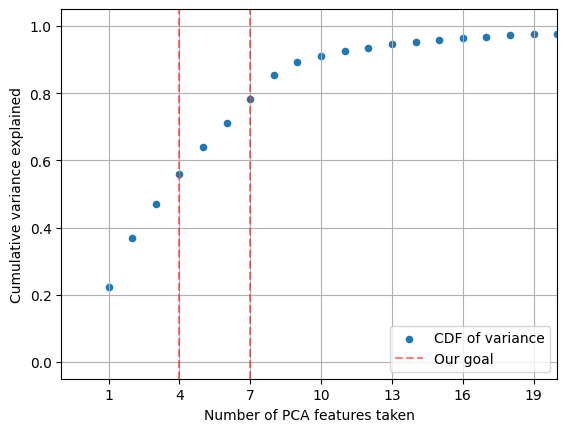

In [7]:
to_transform = df_features.drop(columns = ['date_time','timestamp'])
pca = PCA(n_components = np.shape(to_transform)[1])
transformed = pca.fit_transform(to_transform.values)
cumulative_ratio = np.cumsum(pca.explained_variance_ratio_)

print('shape of input:',np.shape(to_transform))
plt.scatter(np.arange(1,len(cumulative_ratio)+1,1),cumulative_ratio, s = 20, label = 'CDF of variance')
plt.axvline(x = 4, color = 'red', ls = '--',label = 'Our goal', alpha = 0.5)
plt.axvline(x = 7, color = 'red', ls = '--', alpha = 0.5)
plt.xticks(np.arange(1,len(cumulative_ratio)+1,3))
plt.xlim(-1,20)
plt.ylim(-0.05,1.05)
plt.xlabel('Number of PCA features taken')
plt.ylabel('Cumulative variance explained')
plt.grid()
plt.legend()

filename = f'{directory_name}/part1.3_pca.png'
plt.savefig(filename)
plt.show()

## 1.5 Setting up classes
Seen that we need VAE to retrieve more informative features, we have to decide how to setup the classes for the classification. We plot an histogram of ratio, and a cdf of ratio to see where to put a reasonable cutoff value.

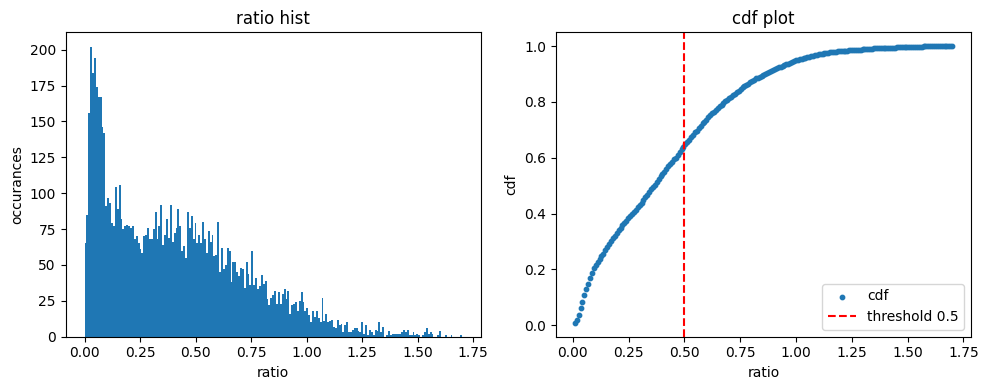

In [8]:
nbins = 200
thresholds = [0.5]

fig, ax = plt.subplots(1, 2, figsize=(10, 4)) 
hist = ax[0].hist(df_labels['ratio'], bins = np.linspace(0,max(df_labels['ratio']),nbins))
ax[0].set_xlabel('ratio')
ax[0].set_ylabel('occurances')
ax[0].set_title('ratio hist')

freq = hist[0]
cdf = np.cumsum(freq)
cdf = cdf / max(cdf)
x_axis = np.linspace(0,max(df_labels['ratio']),nbins)
x_axis = x_axis[1:]
ax[1].scatter(x_axis, cdf, s = 10, label = 'cdf')
ax[1].set_xlabel('ratio')
ax[1].set_ylabel('cdf')
ax[1].set_title('cdf plot')

for threshold in thresholds:
    ax[1].axvline(x=threshold, color='r', linestyle='--', label =f'threshold {threshold}')
ax[1].legend()

plt.tight_layout()
filename = f'{directory_name}/part1.4_ratio_hist_cdf.png'
plt.savefig(filename)
plt.show()

Looking at the distribution, it is reasonable to split at 1 (to have a meaningful physical information)

In [9]:
class_idx = 0
new_thresholds = [0] + thresholds + [max(df_labels['ratio'])]

df_labels['class'] = np.zeros(len(df_labels.index))

print('class intervals:',new_thresholds)
# Assign class based on interval
for i in range(len(new_thresholds) - 1):
    mask = (df_labels['ratio'] > new_thresholds[i]) & (df_labels['ratio'] <= new_thresholds[i + 1])
    df_labels.loc[mask, 'class'] = class_idx
    class_idx += 1

# Check number of datapoints in each class
all_classes = np.unique(df_labels['class'])
tot = len(df_labels['class'])

for class_ in all_classes:
    occ = np.sum(df_labels['class'] == class_)
    print(f'class {int(class_)} occurs {occ} times: {occ/tot:.2%}')


class intervals: [0, 0.5, 1.6993144233419077]
class 0 occurs 5338 times: 64.52%
class 1 occurs 2936 times: 35.48%


/tmp/ipykernel_9846/1236615827.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_labels['class'] = np.zeros(len(df_labels.index))


### 1.6 Removing redundant time information

In meteo forecast data, both (day, month) and dayoftheyear represent the same time information. We pick one to remove and keep sin and cos of the other. In the code dayoftheyear is implemented

In [10]:
# keeping only dayofthe year
df = df_features
features = ['day_sin_t-0','day_cos_t-0',
           'day_sin_t-1','day_cos_t-1',
           'day_sin_t-2','day_cos_t-2',
           'day_sin_t-3','day_cos_t-3',
           'day_sin_t-4','day_cos_t-4',
           'day_sin_t-5','day_cos_t-5',
           'day_sin_t-6','day_cos_t-6',
           'day_sin_t-7','day_cos_t-7',
           'day_sin_t-8','day_cos_t-8',
           'month_sin_t-0','month_cos_t-0',
           'month_sin_t-1','month_cos_t-1',
           'month_sin_t-2','month_cos_t-2',
           'month_sin_t-3','month_cos_t-3',
           'month_sin_t-4','month_cos_t-4',
           'month_sin_t-5','month_cos_t-5',
           'month_sin_t-6','month_cos_t-6',
           'month_sin_t-7','month_cos_t-7',
           'month_sin_t-8','month_cos_t-8']

# in alternative one can use the following lines to keep day and month
'''
features = ['sin_dayofyear_t0','cos_dayofyear_t0',
            'sin_dayofyear_t1','cos_dayofyear_t1',
            'sin_dayofyear_t2','cos_dayofyear_t2',
            'sin_dayofyear_t3','cos_dayofyear_t3',
            'sin_dayofyear_t4','cos_dayofyear_t4',
            'sin_dayofyear_t5','cos_dayofyear_t5',
            'sin_dayofyear_t6','cos_dayofyear_t6',
            'sin_dayofyear_t7','cos_dayofyear_t7',
            'sin_dayofyear_t8','cos_dayofyear_t8'
            ]
'''

df = df.drop(columns = features)
timestamp = pd.to_datetime(df['timestamp'])

timestamp_backup = timestamp.copy()

################################################
# SOFIA
# questo vettore (timestamp) è quello che puoi usare per colorare diversamente i punti secondo un certo criterio
# al momento sta usando i dati di produzione di noemi (quelli un po' scrausi)
# se vuoi vedere cosa succede per le diverse stagioni puoi provare a cambiare con queste righe:
#timestamp = timestamp.dt.hour
#timestamp = [1 if x in [1,2,3] else 2 if x in [4,5,6] else 3 if x in [7,8,9] else 4 if x in [10,11,12] for x in timestamp]

timestamp = df_labels['class']
# una volta che hai buttato dentro quello che vuoi fai andare il codice (se non va fai andare anche la cella
# sopra che c'è un drop qui)
##################################################
# to save indexes for plotting later
timestamp_tensor = torch.tensor(timestamp, dtype = torch.float32)  # Encodes strings to integers

df.drop('timestamp', axis=1, inplace=True)

print("Input Dataframe Dim:", df.shape)
df


Input Dataframe Dim: (8274, 91)


year_t-8    2t_t-8  solar_t-8    tp_t-8  ws_10m_t-8  ws_100m_t-8  \
0    -1.226557 -0.921167  -0.815619 -0.332098   -0.991173    -1.025039   
1    -1.226557 -0.937612  -0.815619 -0.332098   -1.188849    -1.302006   
2    -1.226557 -0.982313  -0.815619 -0.332098   -1.032678    -0.930655   
3    -1.226557 -1.029024  -0.691544 -0.327519   -1.014892    -0.898040   
4    -1.226557 -0.875941   0.292701 -0.327519   -0.693166    -0.622782   
...        ...       ...        ...       ...         ...          ...   
8269  1.223306 -0.385836   0.708817 -0.365028   -0.886782    -1.069865   
8270  1.223306 -0.471876  -0.404439 -0.365028   -1.067655    -1.074726   
8271  1.223306 -1.160591  -0.815619 -0.364210   -1.061923    -1.157216   
8272  1.223306 -1.160591  -0.815619 -0.364210   -1.061923    -1.157216   
8273  1.223306 -1.405128  -0.815619 -0.364210   -1.087543    -1.195631   

      hour_sin_t-8  hour_cos_t-8  sin_dayofyear_t-8  cos_dayofyear_t-8  ...  \
0        -0.685045      1.414467           0.021088           1.294049  ...   
1         0.249487      1.896769           0.045923           1.293430  ...   
2         1.184020      1.414467           0.045923           1.293430  ...   
3         1.571116      0.250088           0.045923           1.293430  ...   
4         1.184020     -0.914291           0.045923           1.293430  ...   
...            ...           ...                ...                ...  ...   
8269      0.249487     -1.396592          -0.053297           1.293434  ...   
8270     -0.685045     -0.914291          -0.053297           1.293434  ...   
8271     -1.072142      0.250088          -0.053297           1.293434  ...   
8272     -1.072142      0.250088          -0.053297           1.293434  ...   
8273     -0.685045      1.414467          -0.053297           1.293434  ...   

        2t_t-0  solar_t-0    tp_t-0  ws_10m_t-0  ws_100m_t-0  hour_sin_t-0  \
0    -0.876109  -0.815618 -0.348761   -0.347113    -0.193410     -1.071912   
1    -1.010828  -0.815618 -0.348761   -0.186938    -0.146222     -0.684841   
2    -1.081329  -0.815618 -0.348761   -0.163417    -0.173794      0.249630   
3    -1.061398  -0.815618 -0.348761    0.108966     0.101606      1.184102   
4    -1.107241  -0.697102 -0.352584    0.215409     0.262543      1.571172   
...        ...        ...       ...         ...          ...           ...   
8269 -1.175651   0.482565 -0.364126   -1.272673    -1.249072      1.184102   
8270 -0.369154   0.718500 -0.364126   -1.329032    -1.343023      0.249630   
8271 -0.476938  -0.396620 -0.364126   -1.278977    -1.242803     -0.684841   
8272 -0.995028  -0.815618 -0.362531   -1.166875    -1.148100     -1.071912   
8273 -0.995028  -0.815618 -0.362531   -1.166875    -1.148100     -1.071912   

      hour_cos_t-0  sin_dayofyear_t-0  cos_dayofyear_t-0           date_time  
0         0.250340           0.045968           1.293428 2022-01-02 18:00:00  
1         1.414968           0.045968           1.293428 2022-01-02 21:00:00  
2         1.897372           0.070789           1.292396 2022-01-03 00:00:00  
3         1.414968           0.070789           1.292396 2022-01-03 03:00:00  
4         0.250340           0.070789           1.292396 2022-01-03 06:00:00  
...            ...                ...                ...                 ...  
8269     -0.914287          -0.028485           1.294048 2024-12-30 09:00:00  
8270     -1.396691          -0.028485           1.294048 2024-12-30 12:00:00  
8271     -0.914287          -0.028485           1.294048 2024-12-30 15:00:00  
8272      0.250340          -0.028485           1.294048 2024-12-30 18:00:00  
8273      0.250340          -0.028485           1.294048 2024-12-30 18:00:00  

[8274 rows x 91 columns]

## 1.7: Making the datasets 

Now we need to decide how to handle the split of the data. Since we are dealing with time series, a correct approach to obtain a meaningful model would be of taking the early points as training sets, and the latter as validation and test. This can be later improved by implementing a traditional or a time aware K-fold

In [11]:
# Custom Dataset
class TabularDataset(torch.utils.data.Dataset):
    # data tensor contains the data itself. timestamp contains information on class points
    def __init__(self, data_tensor, timestamp_tensor):
        self.data = data_tensor
        self.timestamp = timestamp_tensor

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, index):
        return self.data[index], self.timestamp[index], self.timestamp[index] 

In [12]:
# remove the date time information 
df = df.drop(columns = ['date_time'])
features = df.columns   # save features names
data_tensor = torch.tensor(df.values, dtype=torch.float32)  # create the tensor for data

# Split the dataset into train, val, test preserving time order
dataset = TabularDataset(data_tensor, timestamp_tensor)
total_size = len(dataset)
train_size = int(0.7 * total_size) # %70 training, 
val_size = int(0.15 * total_size)  # %15 VALIDATION
test_size = total_size - train_size - val_size # the rest is test

# Compute sizes
total_size = len(dataset)
train_end = int(train_size)
val_end = train_end + int(val_size)

# Create sequential indices
indices = list(range(total_size))

# Create subsets without shuffling
dataset = TabularDataset(data_tensor, timestamp_tensor)
train_dataset = Subset(dataset, indices[:train_end])
val_dataset = Subset(dataset, indices[train_end:val_end])
test_dataset = Subset(dataset, indices[val_end:])

print("Input Dataframe Dim:", df.shape)

Input Dataframe Dim: (8274, 90)


# 2: VAE training and evaluation
After the data processing is now time to train the VAE. The VAE takes the meteo forecast data in input. Since each record contains data related to timestep t and the previous 8 timesteps (from t-1 to t-8), every record is correlated to the previous 24h in a sliding window approach. This also means that every record is made by 90 features!

Hopefully the VAE is able to capture the main meteo forecast features that explain most of the variance, reducing effectively to a number of features that is easy to handle.

## 2.1: VAE structure

In [13]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self, input_dim, h_dim, z_dim):
        super().__init__()
        # encoder
        self.img_2hid = nn.Linear(input_dim, h_dim)
        self.hid_2mu = nn.Linear(h_dim, z_dim)
        self.hid_2sigma = nn.Linear(h_dim, z_dim)
    
        # decoder
        self.z_2hid = nn.Linear(z_dim, h_dim)
        self.hid_2img = nn.Linear(h_dim, input_dim)
    
        self.relu = nn.ReLU()                                 # activation func in hidden layers

    def encode(self, x):
        h = self.relu(self.img_2hid(x))
        mu, sigma = self.hid_2mu(h), self.hid_2sigma(h)
        return mu, sigma

    def decode(self, z):
        h = self.relu(self.z_2hid(z))
        return self.hid_2img(h)

    def forward(self, x):
        mu, sigma = self.encode(x)
        epsilon = torch.randn_like(sigma)
        z_new = mu + sigma*epsilon                            # reparameterization trick
        x_reconstructed = self.decode(z_new)
        return x_reconstructed, mu, sigma

## 2.2: Grid search definition

In [14]:
def train_and_evaluate(hparams, DEVICE, INPUT_DIM, train_loader, val_loader,show_progress = True):
    # Parameters
    H_DIM = hparams['H_DIM']
    NUM_EPOCHS = hparams['NUM_EPOCHS']
    BATCH_SIZE = hparams['BATCH_SIZE']
    LR_RATE = hparams['LR_RATE']
    Z_DIM = hparams['Z_DIM']

    # Model
    model = VariationalAutoEncoder(
        INPUT_DIM,
        H_DIM,
        Z_DIM
    ).to(DEVICE)

    optimizer = optim.Adam(model.parameters(), lr=LR_RATE)
    loss_fn = nn.MSELoss(reduction='sum')

    # Training
    for epoch in range(NUM_EPOCHS):
        epoch_total = 0
        epoch_recon = 0
        epoch_kl = 0
        num_samples = 0

        model.train()
        loop = tqdm(train_loader, desc=f"Z_DIM = {Z_DIM} | Epoch {epoch+1}/{NUM_EPOCHS}", disable = not show_progress)

        for i, (x_batch, t, _) in enumerate(loop):
            x_batch = x_batch.to(DEVICE)
            x_reconstructed, mu, sigma = model(x_batch)

            # Loss
            reconstruction_loss = loss_fn(x_reconstructed, x_batch)
            logvar = torch.log(sigma.pow(2) + 1e-8)
            kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            loss = reconstruction_loss + kl_div

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loop.set_postfix(
                total_loss=loss.item() / x_batch.shape[0],
                reconstruction_loss=reconstruction_loss.item() / x_batch.shape[0],
                kl_div=kl_div.item() / x_batch.shape[0])

            epoch_total += loss.item()
            epoch_recon += reconstruction_loss.item()
            epoch_kl += kl_div.item()
            num_samples += x_batch.shape[0]

    train_loss = epoch_total / num_samples

    # Validation
    model.eval()
    val_total = 0
    val_recon = 0
    val_kl = 0
    val_samples = 0

    with torch.no_grad():
        for x_val, t, _ in val_loader:
            x_val = x_val.to(DEVICE)
            x_reconstructed, mu, sigma = model(x_val)
            reconstruction_loss = loss_fn(x_reconstructed, x_val)
            logvar = torch.log(sigma.pow(2) + 1e-8)
            kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            loss = reconstruction_loss + kl_div

            val_total += loss.item()
            val_recon += reconstruction_loss.item()
            val_kl += kl_div.item()
            val_samples += x_val.size(0)

    val_loss = val_total / val_samples

    return {
        'train_loss': train_loss,
        'val_loss': val_loss,
        'Z_DIM': Z_DIM,
        'H_DIM': H_DIM,
        'LR_RATE': LR_RATE
    }


## 2.3: Running the grid search

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# parameters for grid search
param_grid = {
    'H_DIM': [16,32,48,64],
    'Z_DIM': [4, 5, 6],
    'LR_RATE': [1e-3,1e-4,1e-5],
    'BATCH_SIZE': [128,64],
    'NUM_EPOCHS': [20]
}
INPUT_DIM = data_tensor.shape[1]

# get their possible comb
keys, values = zip(*param_grid.items())
param_combinations = [dict(zip(keys, v)) for v in product(*values)]

best_loss = 1e10
best_params = None

for hparams in tqdm(param_combinations, desc="Grid Search"):
    
    BATCH_SIZE = hparams['BATCH_SIZE']
    train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
    val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE)
    test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE)
    
    out = train_and_evaluate(hparams, device, INPUT_DIM, train_loader, val_loader, show_progress = False)
    train_loss = out['train_loss']
    val_loss = out['val_loss']
    
    if val_loss < best_loss:
        best_loss = val_loss
        best_params = hparams
        print('current lowest validation loss:', val_loss)
        print(f'best params:{best_params} \n')

print("\nBest loss:", best_loss)
print("Best Params:", best_params)

Grid Search:   0%|          | 0/72 [00:00<?, ?it/s]

current lowest validation loss: 67.18017224012893
best params:{'H_DIM': 16, 'Z_DIM': 4, 'LR_RATE': 0.001, 'BATCH_SIZE': 128, 'NUM_EPOCHS': 20} 

current lowest validation loss: 57.2477615196603
best params:{'H_DIM': 16, 'Z_DIM': 4, 'LR_RATE': 0.001, 'BATCH_SIZE': 64, 'NUM_EPOCHS': 20} 

current lowest validation loss: 55.10659443304291
best params:{'H_DIM': 16, 'Z_DIM': 5, 'LR_RATE': 0.001, 'BATCH_SIZE': 128, 'NUM_EPOCHS': 20} 

current lowest validation loss: 54.27442547277901
best params:{'H_DIM': 16, 'Z_DIM': 6, 'LR_RATE': 0.001, 'BATCH_SIZE': 128, 'NUM_EPOCHS': 20} 

current lowest validation loss: 52.80701618056255
best params:{'H_DIM': 32, 'Z_DIM': 5, 'LR_RATE': 0.001, 'BATCH_SIZE': 128, 'NUM_EPOCHS': 20} 

current lowest validation loss: 50.03959671745946
best params:{'H_DIM': 32, 'Z_DIM': 5, 'LR_RATE': 0.001, 'BATCH_SIZE': 64, 'NUM_EPOCHS': 20} 

current lowest validation loss: 44.925081534312675
best params:{'H_DIM': 32, 'Z_DIM': 6, 'LR_RATE': 0.001, 'BATCH_SIZE': 64, 'NUM_EPO

## 2.4 Retraining on best params
We train the VAE again on a higher number of epochs 

In [16]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
INPUT_DIM = data_tensor.shape[1]
H_DIM = best_params['H_DIM']
NUM_EPOCHS = best_params['NUM_EPOCHS'] + 150 # train for lots of epochs
BATCH_SIZE = best_params['BATCH_SIZE']
LR_RATE = best_params['LR_RATE'] 
Z_DIM = best_params['Z_DIM']

all_histories = {}

train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE)

print(f"\nTraining with Z_DIM = {Z_DIM}")
model = VariationalAutoEncoder(INPUT_DIM, H_DIM, Z_DIM).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR_RATE)
loss_fn = nn.MSELoss(reduction="sum")

history = {
      'total_loss': [],
      'reconstruction_loss': [],
      'kl_div': [],
      'val_total_loss': [],
      'val_reconstruction_loss': [],
      'val_kl_div': [],
      'test_loss': None
}
outputs = []
epoch_bar = tqdm(range(NUM_EPOCHS), desc=f"Training Z_DIM = {Z_DIM}")

for epoch in epoch_bar:
    epoch_total = 0
    epoch_recon = 0
    epoch_kl = 0
    num_samples = 0

    model.train()
    
    # Optional: disable or remove batch-level tqdm to reduce clutter
    for i, (x_batch, t, _) in enumerate(train_loader):  # removed inner tqdm here
        #print("Labels in batch:", t)
        x_batch = x_batch.to(DEVICE)
        x_reconstructed, mu, sigma = model(x_batch)

        # Loss Function
        reconstruction_loss = loss_fn(x_reconstructed, x_batch)
        logvar = torch.log(sigma.pow(2) + 1e-8)
        kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = reconstruction_loss + kl_div

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_total += loss.item()
        epoch_recon += reconstruction_loss.item()
        epoch_kl += kl_div.item()
        num_samples += x_batch.shape[0]

        if i == 0:
            outputs.append((epoch, x_batch.clone(), x_reconstructed.clone()))

    # Store epoch losses
    history['total_loss'].append(epoch_total / num_samples)
    history['reconstruction_loss'].append(epoch_recon / num_samples)
    history['kl_div'].append(epoch_kl / num_samples)

    # Validation step
    model.eval()
    val_total = 0
    val_recon = 0
    val_kl = 0
    val_samples = 0

    with torch.no_grad():
        for x_val, t, _ in val_loader:
            x_val = x_val.to(DEVICE)
            x_reconstructed, mu, sigma = model(x_val)
            loss_rec = loss_fn(x_reconstructed, x_val)
            logvar = torch.log(sigma.pow(2) + 1e-8)
            kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            loss = loss_rec + kl_div

            val_total += loss.item()
            val_recon += loss_rec.item()
            val_kl += kl_div.item()
            val_samples += x_val.size(0)

    history['val_total_loss'].append(val_total / val_samples)
    history['val_reconstruction_loss'].append(val_recon / val_samples)
    history['val_kl_div'].append(val_kl / val_samples)

    # Update the epoch progress bar with losses info
    epoch_bar.set_postfix({
        "Train Loss": f"{history['total_loss'][-1]:.4f}",
        "Val Loss": f"{history['val_total_loss'][-1]:.4f}"
    })



Training with Z_DIM = 6


Training Z_DIM = 6:   0%|          | 0/170 [00:00<?, ?it/s]

### 2.5: visualizing the latent space
We can use the trained VAE to produce the latent vectors corresponding to all datapoints given as inputs. The latent space is then visualized exploiting PCA

explained variance: [0.2098309  0.19271804 0.17946124 0.1568633  0.14374757 0.11737894]
(8274, 6)


<Figure size 750x500 with 0 Axes>

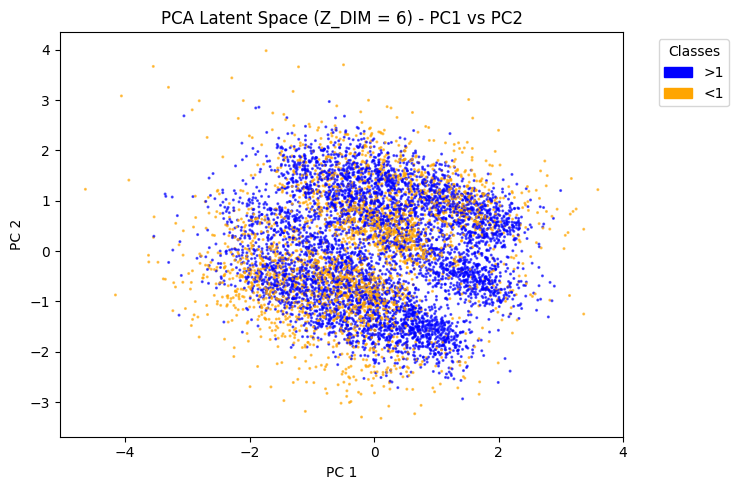

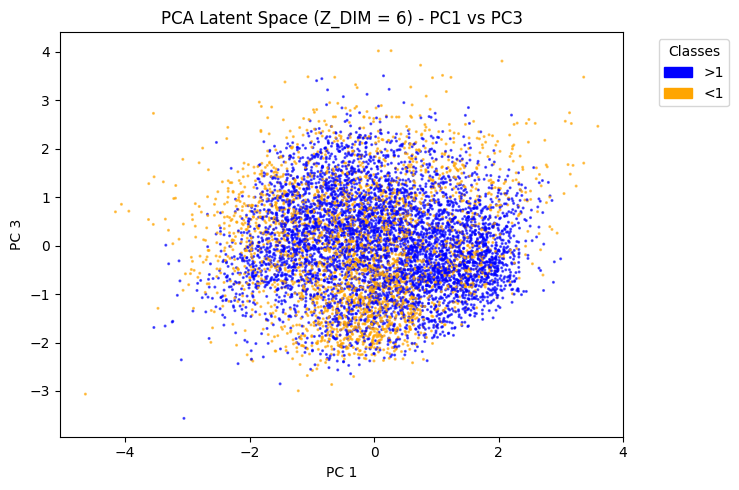

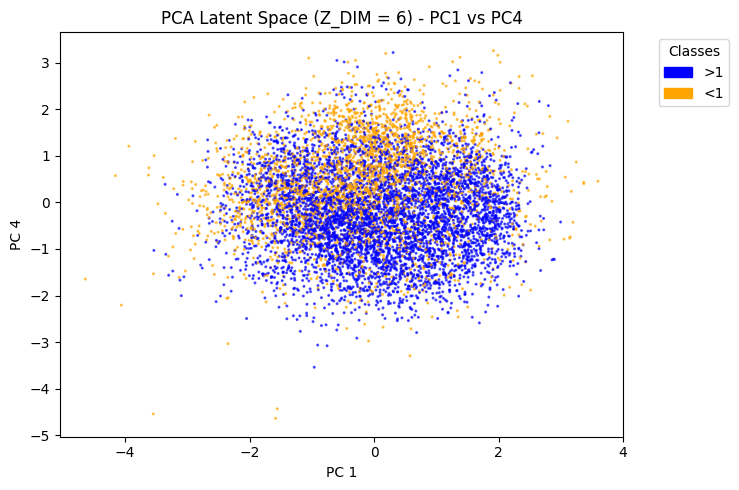

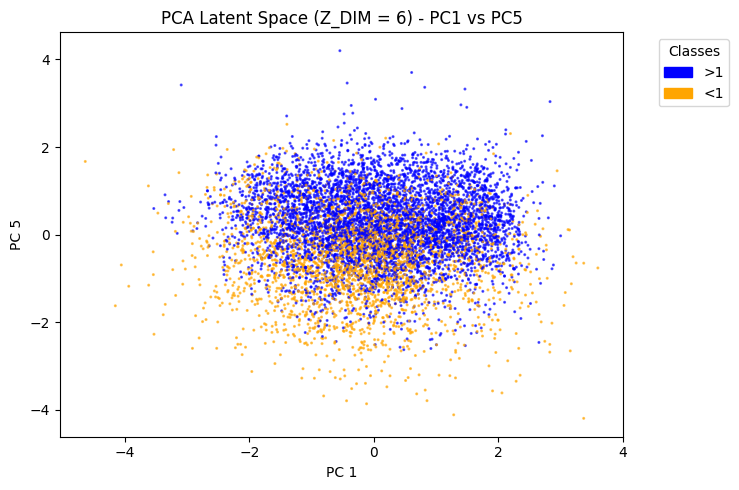

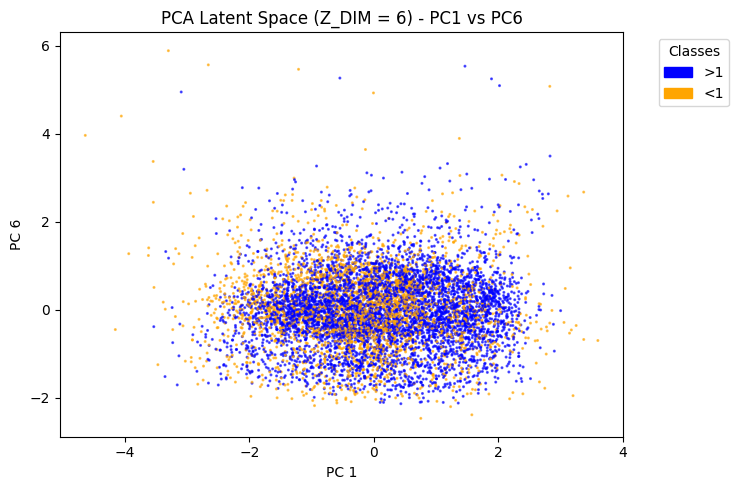

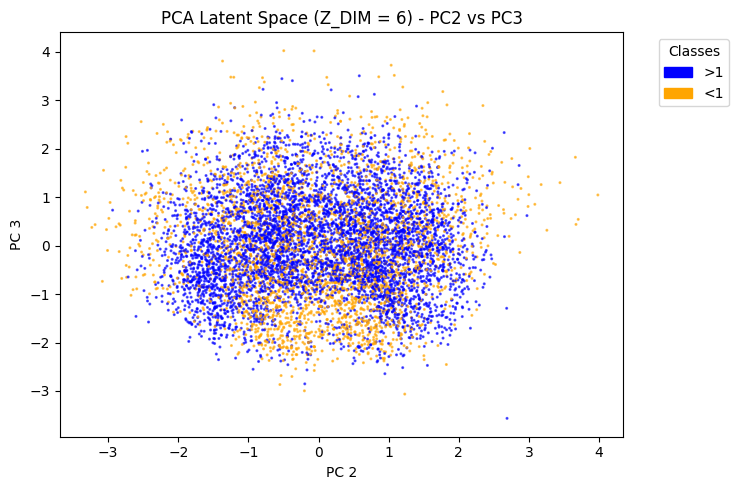

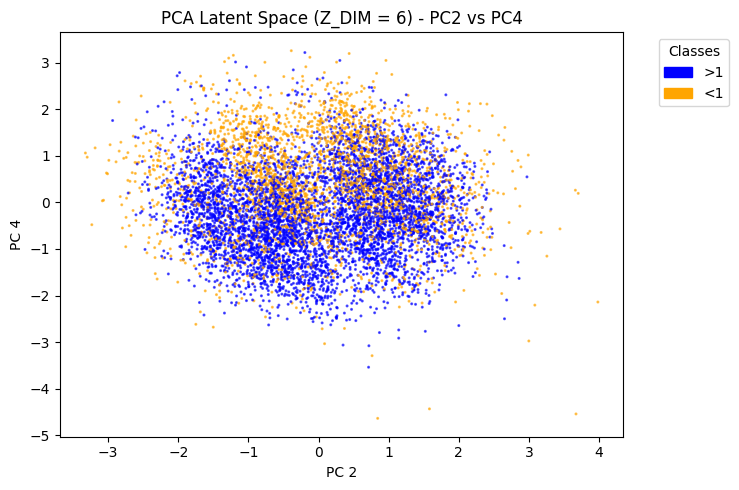

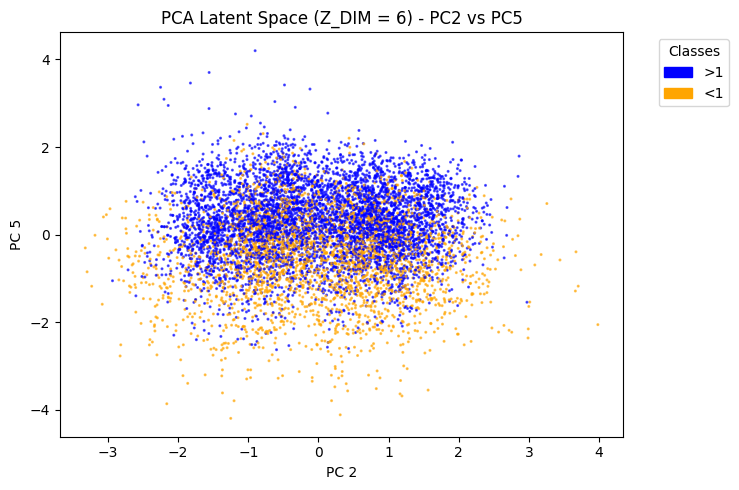

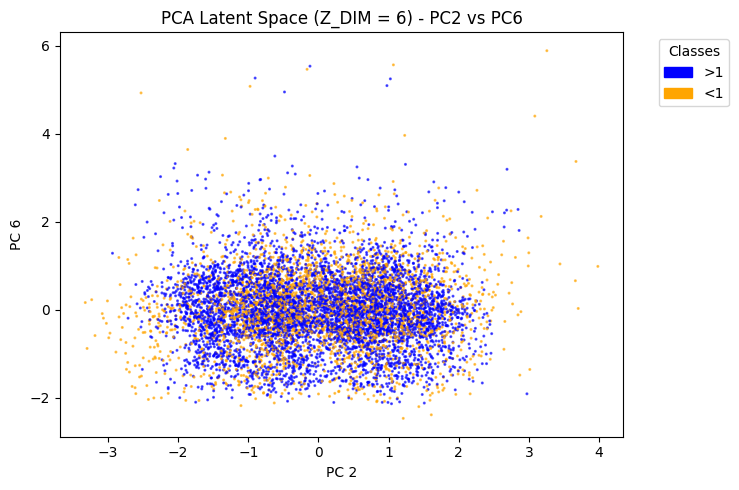

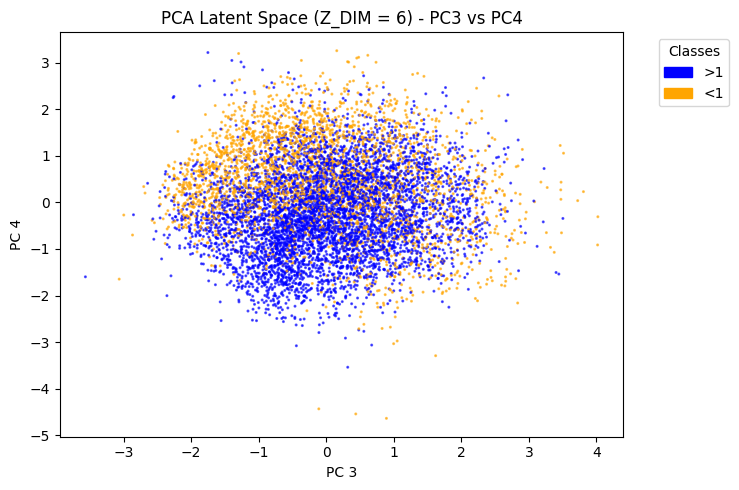

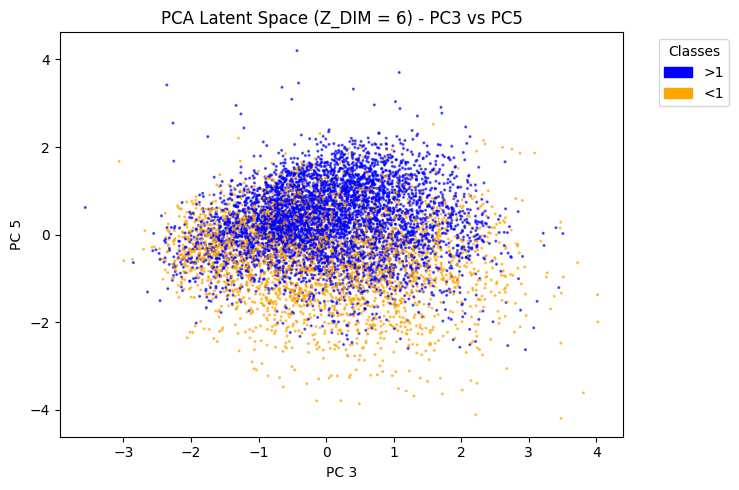

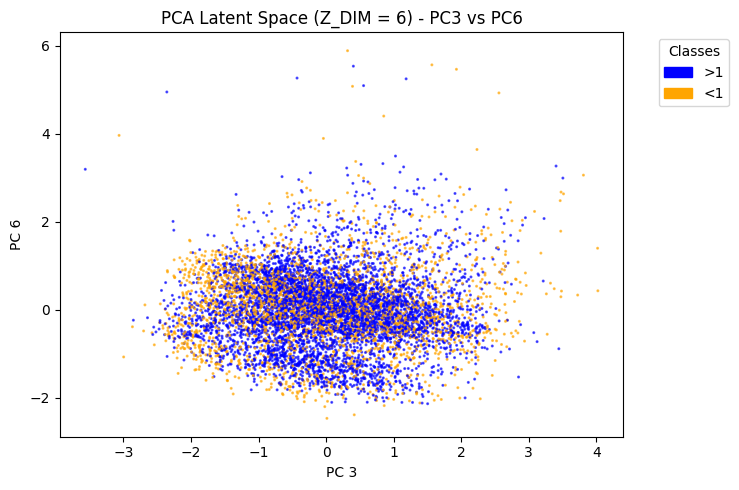

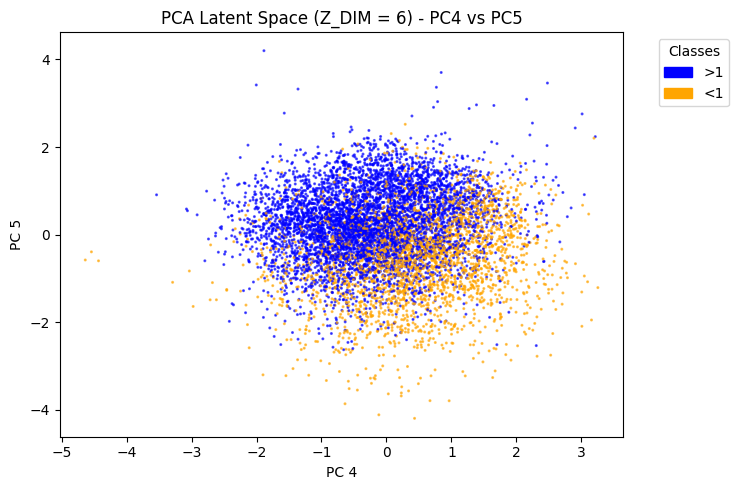

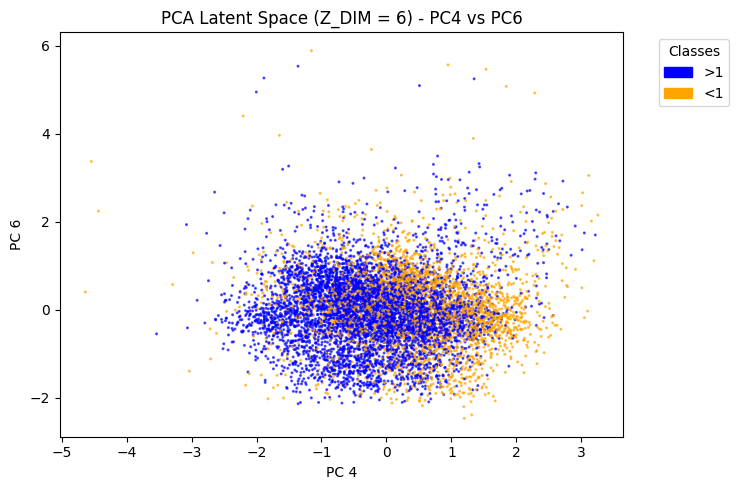

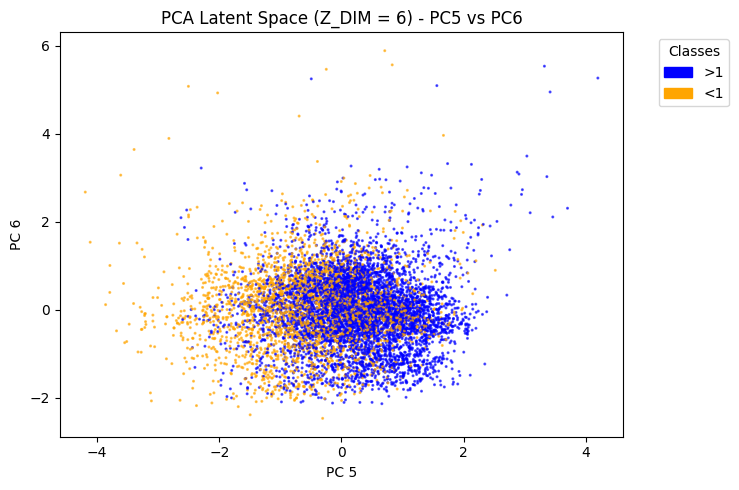

In [17]:

# get the latent vectors (test set)
zs = []
ts = []
reconstructed = []
original = []

model.eval()
with torch.no_grad():
    # train set
    for x_train, t, _ in train_loader:
        x_train = x_train.to(DEVICE)
        x_reconstructed, mu, sigma = model(x_train)
        epsilon = torch.randn_like(sigma)
        
        # compute z via reparameterization trick
        z = mu + sigma * epsilon
        zs.append(z.cpu())  # vector
        ts.append(t)  # class information
        original.append(x_train.cpu().numpy())
        reconstructed.append(x_reconstructed.cpu().numpy())
        
    # validation set
    for x_val, t, _ in val_loader:
        x_val = x_val.to(DEVICE)
        x_reconstructed, mu, sigma = model(x_val)
        epsilon = torch.randn_like(sigma)
        
        # compute z via reparameterization trick
        z = mu + sigma * epsilon
        zs.append(z.cpu())  # vector
        ts.append(t)  # class information
        original.append(x_val.cpu().numpy())
        reconstructed.append(x_reconstructed.cpu().numpy())

    # test set
    for x_test, t, _ in test_loader:
        x_test = x_test.to(DEVICE)
        x_reconstructed, mu, sigma = model(x_test)
        epsilon = torch.randn_like(sigma)
        
        # compute z via reparameterization trick
        z = mu + sigma * epsilon
        zs.append(z.cpu())  # vector
        ts.append(t)  # class information
        original.append(x_test.cpu().numpy())
        reconstructed.append(x_reconstructed.cpu().numpy())

zs = torch.cat(zs, dim=0)  # (total_samples, latent_dim)
zs = zs.numpy()          # convert to numpy array
ts = torch.cat(ts, dim=0)
ts = ts.numpy()

pca = PCA(n_components = best_params['Z_DIM'])
zs_pca = pca.fit_transform(zs)
print('explained variance:',pca.explained_variance_ratio_)

print(np.shape(zs_pca))
plt.figure(figsize = (7.5, 5))


############################
# SOFIA
# qui ci sono un paio di cose che dovresti ritoccare per i plot
# colors handling
unique_ts = np.unique(ts)
# vengono usati solo i primi n colori (dove n numero di diverse categorie in timestamp
custom_colors = ['blue','orange', 'green','#006064','lightblue','#1B5E20', 'green', 'brown','orange','yellow','pink','red','#FFEB3B','#FAF4C4','#FAF4C4',]  
keep_colors = custom_colors[:len(unique_ts)]
custom_colormap = ListedColormap(custom_colors[:len(unique_ts)])
# legend
# qui dovresti scrivere a mano a che cosa corrisponde ogni categoria
# custom_labels = ['winter','spring','summer','autumn']
custom_labels = ['>1',
                 '<1']
#############################
legend_handles = [
    Patch(color=keep_colors[i], label=custom_labels[i]) for i in range(len(unique_ts))
]

# Plot all 2D combinations of PCA components
combinations = list(itertools.combinations(range(zs_pca.shape[1]), 2))
for i, (x_idx, y_idx) in enumerate(combinations):
    plt.figure(figsize=(7.5, 5))
    
    scatter = plt.scatter(zs_pca[:, x_idx], zs_pca[:, y_idx], c=ts, cmap=custom_colormap, s=1.4, alpha = 0.6)
    
    plt.title(f"PCA Latent Space (Z_DIM = {Z_DIM}) - PC{x_idx+1} vs PC{y_idx+1}")
    plt.xlabel(f"PC {x_idx+1}")
    plt.ylabel(f"PC {y_idx+1}")
    
    plt.legend(handles=legend_handles, title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
    #plt.colorbar(label='Generation trend')
    plt.tight_layout()
    
    filename = f'{directory_name}/part2.5_latent_space_pca_{x_idx}_{y_idx}.png'
    plt.savefig(filename)
    #plt.savefig(f"PCA_output/ZDIM_{Z_DIM}_PC{x_idx}_{y_idx}.png")
    plt.show()

## 2.6: reconstructing the input
Other than creating an efficient latent space for classification, a VAE must also be able to reconstruct the starting features from its latent space. We can visualize the results to check wheter this is true or not

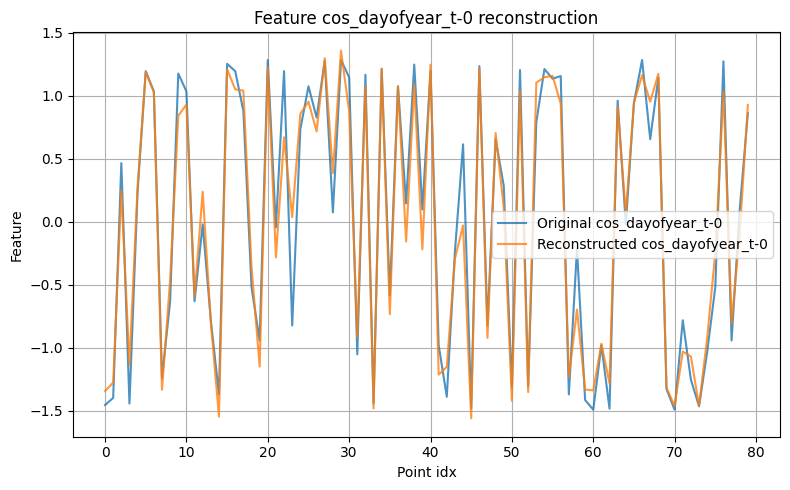

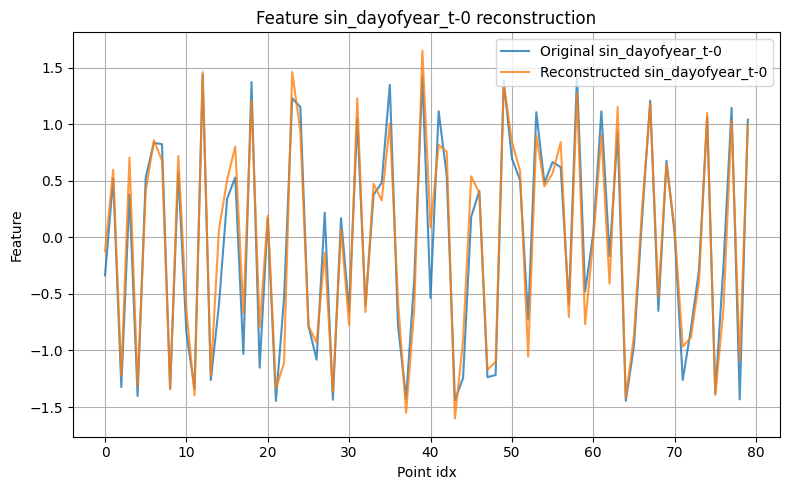

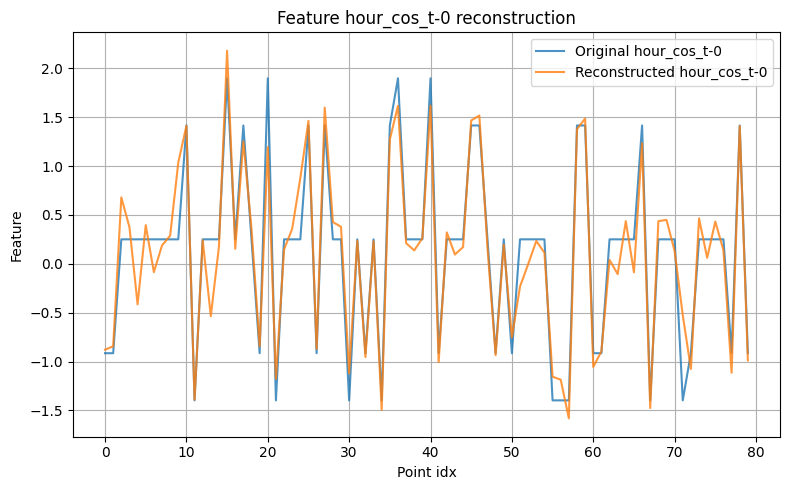

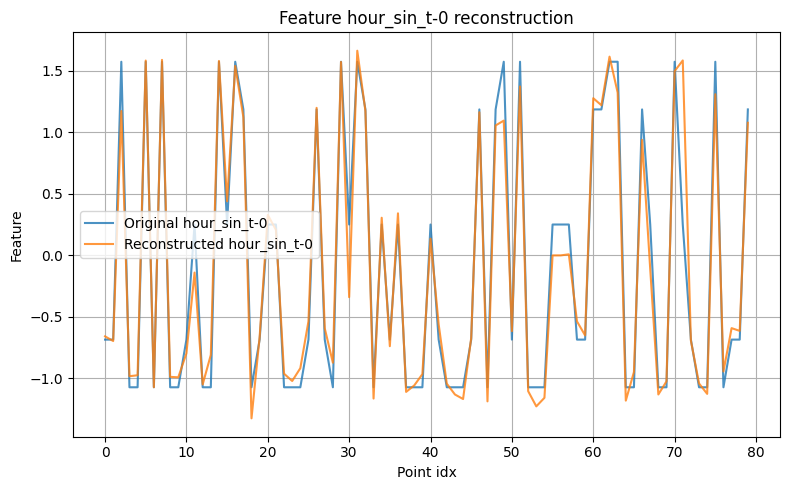

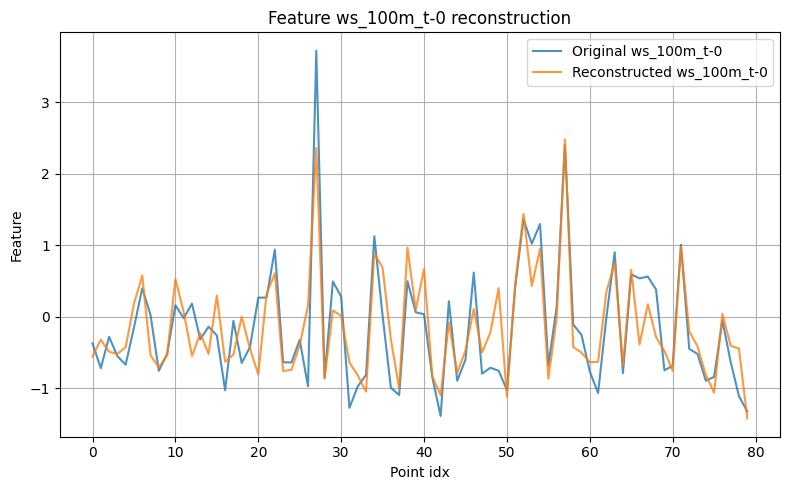

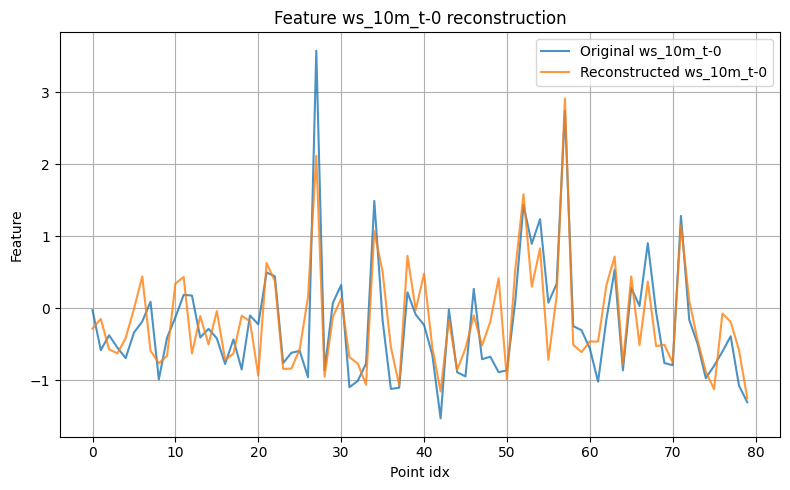

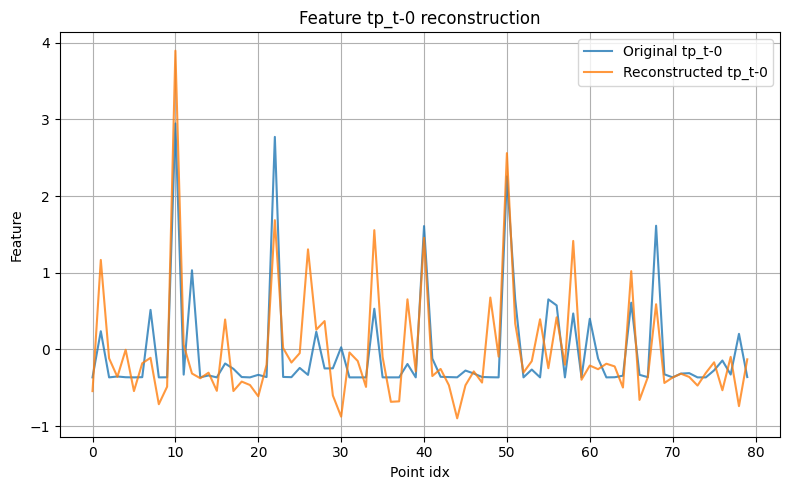

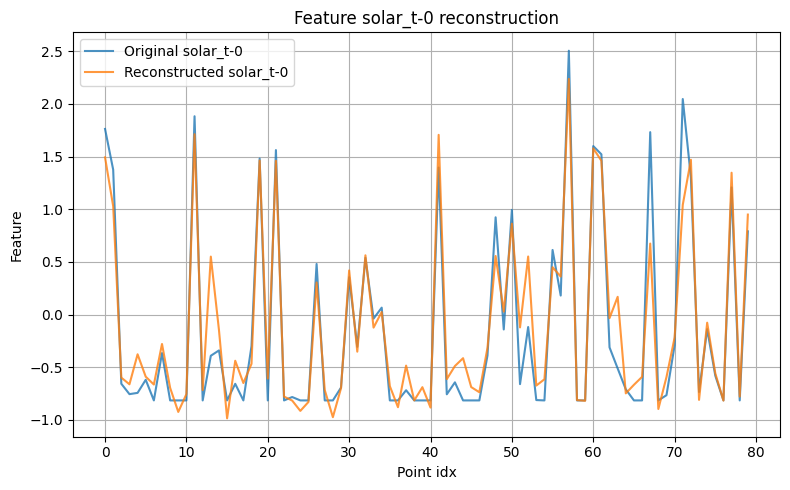

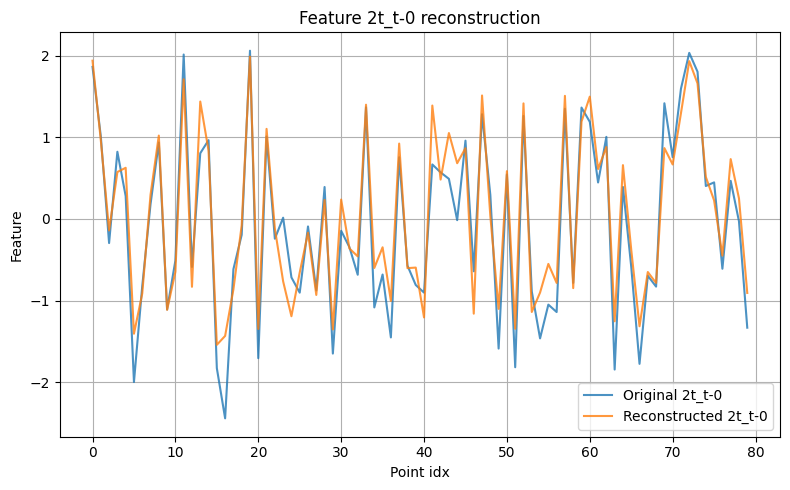

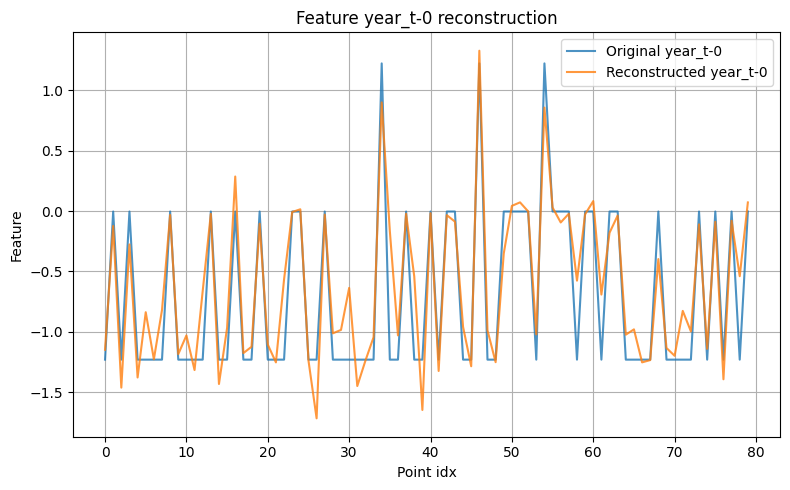

In [18]:
# concatenate all batches
original_all = np.concatenate(original, axis=0)       
reconstructed_all = np.concatenate(reconstructed, axis=0)
#print(np.shape(original_all),np.shape(reconstructed_all))
features_to_plot = [-1,-2,-3,-4,-5,-6,-7,-8,-9,-10]
dummy_x = np.arange(0,np.shape(original_all)[0],1)
points_to_plot = 80

for feature_idx in features_to_plot:
    
    plt.figure(figsize=(8, 5))
    plt.plot(dummy_x[:points_to_plot],
                original_all[:, feature_idx][:points_to_plot],
                alpha=0.8, label=f'Original {features[feature_idx]}')
    plt.plot(dummy_x[:points_to_plot],
                reconstructed_all[:, feature_idx][:points_to_plot],
                alpha=0.8, label=f'Reconstructed {features[feature_idx]}')
    plt.xlabel("Point idx")
    plt.ylabel("Feature")
    plt.title(f"Feature {features[feature_idx]} reconstruction")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    filename = f'{directory_name}/part2.6_feature_reconstruction_{feature_idx}.png'
    plt.savefig(filename)
    plt.show() 

## 2.7: Loss plot
A check on the performance can be done on the loss plot across the epochs: the trend must be generally decreasing, while the single components should 

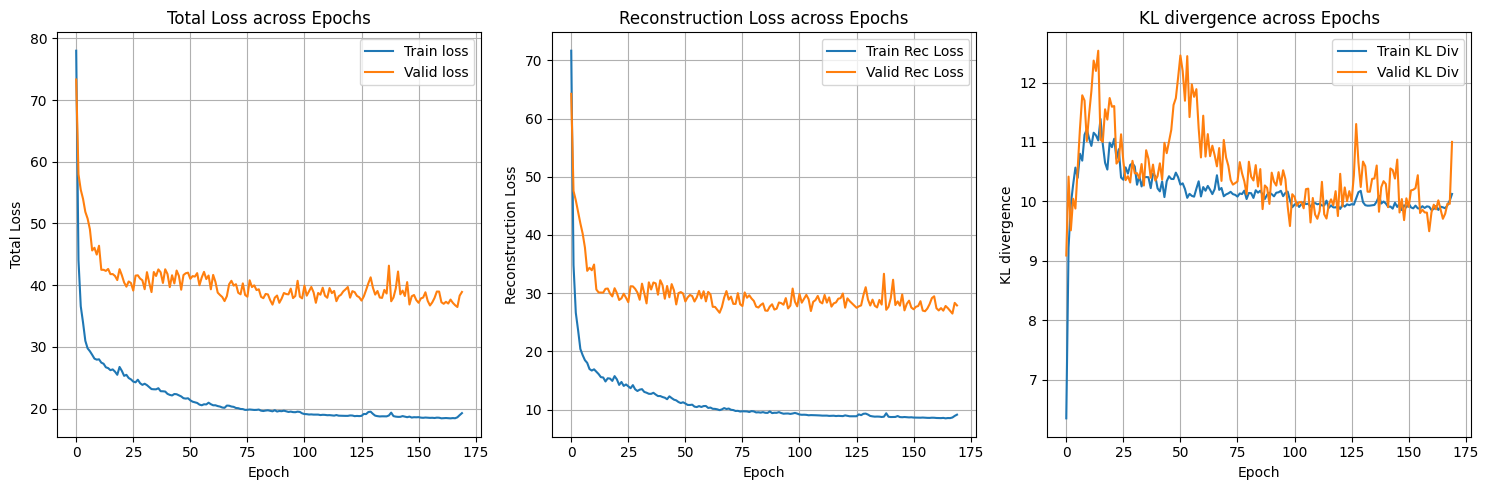

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=False)
ymin, ymax = 0, 140

epochs = np.arange(0,NUM_EPOCHS ,1)
# Plot of Total Loss
axs[0].plot(epochs,history['total_loss'], label = 'Train loss')
axs[0].plot(epochs,history['val_total_loss'], label = 'Valid loss')
axs[0].set_ylabel("Total Loss")
axs[0].set_xlabel("Epoch")
axs[0].set_title("Total Loss across Epochs")
axs[0].legend()
axs[0].grid(True)

# Plot of Reconstruction Loss
axs[1].plot(epochs,history['reconstruction_loss'], label = 'Train Rec Loss')
axs[1].plot(epochs,history['val_reconstruction_loss'], label = 'Valid Rec Loss')
axs[1].set_ylabel("Reconstruction Loss")
axs[1].set_xlabel("Epoch")
axs[1].set_title("Reconstruction Loss across Epochs")
axs[1].legend()
axs[1].grid(True)

# Plot of KL Divergence
axs[2].plot(epochs,history['kl_div'], label = 'Train KL Div')
axs[2].plot(epochs,history['val_kl_div'], label = 'Valid KL Div')
axs[2].set_ylabel("KL divergence")
axs[2].set_xlabel("Epoch")
axs[2].set_title("KL divergence across Epochs")
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
filename = f'{directory_name}/part2.7_losses.png'
plt.savefig(filename)
plt.show()

# 3: Attach a NN in tail of the VAE
After having trained the VAE, we freeze it and its structure and use it to compute the latent vectors correspondant to all of our records. The so obtained data has a reduced dimensionality which coincides with the dimension of the latent space. These, with features regarding the installation, are the inputs of the NN in charge of the classification
## 3.1 Model definition

In [20]:
class SimpleClassifier(nn.Module):
    def __init__(self, z_dim, x_extra_dim, hidden_dims, output_dim, dropout_prob = 0.3):
        super(SimpleClassifier, self).__init__()
        input_dim = z_dim + x_extra_dim

        self.fc1 = nn.Linear(input_dim, hidden_dims[0])
        self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
        self.output = nn.Linear(hidden_dims[1], output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_prob) 

    def forward(self, zs, x_extra):
        #print('zs:', zs.shape, 'x_extra:', x_extra.shape)

        x = torch.cat((zs, x_extra), dim=1)  # concatenate along feature dimension
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        logits = self.output(x)
        return logits

## 3.2: Data preparation
First off we need to compute the latent vectors of all of our inputs and standard scale them (installation features were already scaled above)

In [21]:
class CombinedDataset(Dataset):
    def __init__(self, zs_tensor, X_extra, Y):
        self.zs = zs_tensor
        self.X_extra = X_extra
        self.Y = Y

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        return self.zs[idx], self.X_extra[idx], self.Y[idx]

In [93]:
# compute all hidden vectors

model.eval()  # set to evaluation mode
device = 'cpu'
data_tensor = data_tensor.to(device)  # move input to same device as model

with torch.no_grad():
    mu, logvar = model.encode(data_tensor)
    zs = mu.cpu().numpy()

# save hidden vectors
print(np.shape(zs))
print(np.shape(df_labels))
hidden_vectors = zs

# scale the hidden vectors
scaler_z = StandardScaler()
scaler_z.fit(zs)
scaled_zs = scaler_z.transform(zs)

(8274, 6)
(8274, 6)


In [94]:
# trying a different approach on installation features
'''df_labels['scaled_solar_installed'] = df_labels['scaled_solar_installed'] / (df_labels['scaled_solar_installed'] + df_labels['scaled_wind_installed'] + df_labels['scaled_hydro_installed'])
df_labels['scaled_wind_installed'] = df_labels['scaled_wind_installed'] / (df_labels['scaled_solar_installed'] + df_labels['scaled_wind_installed'] + df_labels['scaled_hydro_installed'])
df_labels['scaled_hydro_installed'] = df_labels['scaled_hydro_installed'] / (df_labels['scaled_solar_installed'] + df_labels['scaled_wind_installed'] + df_labels['scaled_hydro_installed'])
'''
# take inputs and make them torch tensors
X_extra = torch.tensor(df_labels[['scaled_solar_installed','scaled_hydro_installed','scaled_wind_installed']].values, dtype=torch.float32)
Y = torch.tensor(df_labels['class'].values, dtype=torch.long)  # this is the classification target

# check the classes
print('All different classes:',torch.unique(Y))

# check the latent vector tensor
if isinstance(zs, np.ndarray):
    zs_tensor = torch.tensor(scaled_zs, dtype=torch.float32)
else:
    zs_tensor = scaled_zs  # already a tensor

# divide the dataset (70% training 15% validation 15% test set)
full_dataset = CombinedDataset(zs_tensor, X_extra, Y)
indices = list(range(total_size))
train_dataset = Subset(full_dataset, indices[:train_end])
val_dataset = Subset(full_dataset, indices[train_end:val_end])
test_dataset = Subset(full_dataset, indices[val_end:])

print('zs_tensor shape:', zs_tensor.shape)       # e.g. (N, z_dim)
print('X_extra shape:', X_extra.shape)     

z_dim = zs_tensor.shape[1]
x_extra_dim = X_extra.shape[1]


All different classes: tensor([0, 1])
zs_tensor shape: torch.Size([8274, 6])
X_extra shape: torch.Size([8274, 3])


## 3.3: balancing the classes
Since our classes could be unbalanced, to prevent the NN to be biased towards the majority class, we throw a balancing weight parameter according to the distributions of the classes

In [95]:
def class_distribution(subset):
    labels = [subset[i][2].item() for i in range(len(subset))]
    return np.bincount(labels)

print("Train class distribution:", class_distribution(train_dataset))
print("Val class distribution:", class_distribution(val_dataset))
print("Test class distribution:", class_distribution(test_dataset))


Train class distribution: [3874 1917]
Val class distribution: [677 564]
Test class distribution: [787 455]


In [96]:
# Get unique class labels and compute weights
class_labels = np.unique(Y.numpy())
weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=Y.numpy())
weights = torch.tensor(weights, dtype=torch.float32).to(device)

print("Class weights:", weights)


Class weights: tensor([0.7750, 1.4091])


## 3.4: training the NN
As done for the VAE, we run a grid search on the hyperparameters space to retrieve the best configuration of the NN

In [98]:
device = 'cpu'

num_epochs = 15
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the search space
param_grid = {
    'hidden_dims': [[64, 32], [32,16], [16,8], [8,4]],
    'lr': [1e-4, 1e-3],
    'batch_size': [64, 128],
    'weight_decay': [1e-2,1e-3,1e-4],
    'dropout_prob': [0.05,0.15,0.3] 
}

# Create all combinations of parameters
param_combinations = list(product(*param_grid.values()))

correct = 0
total = 0
# Best tracking
best_val_accuracy = 0.0
best_model = None
best_params = None

# Grid search loop
for params in tqdm(param_combinations, desc="Grid Search"):
    hidden_dims, lr, batch_size, weight_decay, dropout_prob = params
    #print(f"\nTraining with: hidden_dims={hidden_dims}, lr={lr}, batch_size={batch_size}, weight_decay={weight_decay}, dropout_prob={dropout_prob}")

    # Update loaders with batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Initialize model, loss, optimizer
    modelNN = SimpleClassifier(z_dim = z_dim,
                               x_extra_dim = x_extra_dim,
                               hidden_dims=hidden_dims,
                               output_dim=len(torch.unique(Y))+1,
                               dropout_prob=dropout_prob
                              ).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(modelNN.parameters(), lr=lr, weight_decay = weight_decay)

    # Training
    for epoch in range(num_epochs):
        modelNN.train()
        for zs, x_extra, labels in train_loader:
            zs, x_extra, labels = zs.to(device), x_extra.to(device), labels.to(device)

            optimizer.zero_grad()
            logits = modelNN(zs, x_extra)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

    # Validation
    modelNN.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for zs, x_extra, labels in val_loader:
            zs, x_extra, labels = zs.to(device), x_extra.to(device), labels.to(device)
            logits = modelNN(zs, x_extra)
            _, predicted = torch.max(logits.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    #print(f"Validation Accuracy: {val_accuracy:.2f}%")

    # Save best
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model = modelNN
        best_params = {
            'hidden_dims': hidden_dims,
            'lr': lr,
            'batch_size': batch_size,
            'weight_decay': weight_decay,
            'dropout_prob': dropout_prob
        }
        print(f'New best accuracy obtained! Val accuracy: {best_val_accuracy}')
        print(f'Params: {best_params}')

print("\nBest Hyperparameters:")
print(best_params)
print(f"Best Validation Accuracy: {best_val_accuracy:.2f}%")

Grid Search:   0%|          | 0/144 [00:00<?, ?it/s]

New best accuracy obtained! Val accuracy: 78.1627719580983
Params: {'hidden_dims': [64, 32], 'lr': 0.0001, 'batch_size': 64, 'weight_decay': 0.01, 'dropout_prob': 0.05}
New best accuracy obtained! Val accuracy: 78.40451248992748
Params: {'hidden_dims': [64, 32], 'lr': 0.0001, 'batch_size': 64, 'weight_decay': 0.0001, 'dropout_prob': 0.05}
New best accuracy obtained! Val accuracy: 82.83642224012893
Params: {'hidden_dims': [64, 32], 'lr': 0.001, 'batch_size': 64, 'weight_decay': 0.01, 'dropout_prob': 0.05}
New best accuracy obtained! Val accuracy: 85.4149879129734
Params: {'hidden_dims': [64, 32], 'lr': 0.001, 'batch_size': 64, 'weight_decay': 0.001, 'dropout_prob': 0.05}

Best Hyperparameters:
{'hidden_dims': [64, 32], 'lr': 0.001, 'batch_size': 64, 'weight_decay': 0.001, 'dropout_prob': 0.05}
Best Validation Accuracy: 85.41%


## 3.5: Retraining with best parameters

Training Epochs:   0%|          | 0/40 [00:00<?, ?it/s]


Final Validation Accuracy: 83.16%


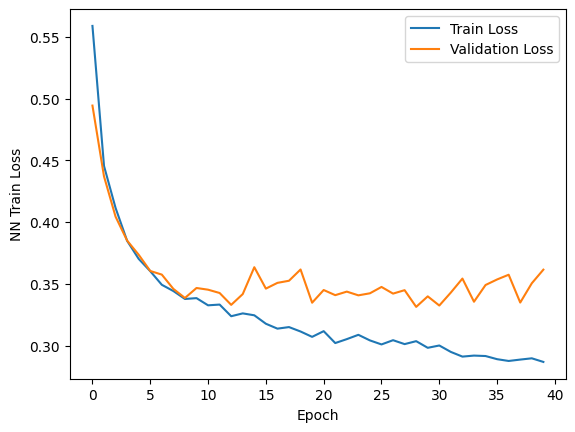

In [140]:
num_epochs = 40
hidden_dims = best_params['hidden_dims']
lr = best_params['lr'] 
batch_size = best_params['batch_size']
weight_decay = best_params['weight_decay']
dropout_prob = best_params['dropout_prob']


train_dataset = Subset(full_dataset, indices[:train_end])
val_dataset = Subset(full_dataset, indices[train_end:val_end])
test_dataset = Subset(full_dataset, indices[val_end:])

modelNN = SimpleClassifier(z_dim = z_dim,
                               x_extra_dim = x_extra_dim,
                               hidden_dims=hidden_dims,
                               output_dim=len(torch.unique(Y)),
                               dropout_prob=dropout_prob
                              ).to(device)

criterion = nn.CrossEntropyLoss(weight = weights)
optimizer = optim.Adam(modelNN.parameters(), lr=lr)

# Update loaders with batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

NNlosses = []
val_losses = []

epoch_bar = tqdm(range(num_epochs), desc="Training Epochs")

for epoch in epoch_bar:
    modelNN.train()
    epoch_loss = 0.0

    for zs, x_extra, labels in train_loader:
        zs, x_extra, labels = zs.to(device), x_extra.to(device), labels.to(device)

        optimizer.zero_grad()
        logits = modelNN(zs, x_extra)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * zs.size(0)

    avg_train_loss = epoch_loss / len(train_loader.dataset)
    NNlosses.append(avg_train_loss)

    # Validation loss
    modelNN.eval()
    val_loss = 0.0
    correct, total = 0, 0

    with torch.no_grad():
        for zs, x_extra, labels in val_loader:
            zs, x_extra, labels = zs.to(device), x_extra.to(device), labels.to(device)
            logits = modelNN(zs, x_extra)
            loss = criterion(logits, labels)

            val_loss += loss.item() * zs.size(0)
            _, predicted = torch.max(logits.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(avg_val_loss)

    val_accuracy = 100 * correct / total
    epoch_bar.set_postfix(train_loss=avg_train_loss, val_loss=avg_val_loss, val_acc=val_accuracy)

print(f"\nFinal Validation Accuracy: {val_accuracy:.2f}%")

plt.plot(np.arange(0,num_epochs,1),NNlosses, label = 'Train Loss')
plt.plot(np.arange(0,num_epochs,1),val_losses, label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('NN Train Loss')
plt.legend()
filename = f'{directory_name}/part3.5_NN_loss.png'
plt.savefig(filename)
plt.show()

# 4: Results visualization

## 4.1: Time-aware accuracy
One of the main goals of our project is to get a working classifier which performance must be generally decreasing in time (since the past is more far away), but hopefully without any drastic drops at any time. A rapid fall in accuracy means that the model is not able to identify specific patterns in the data and fails to interpret them correctly.

In [141]:
def accuracy_score(y_true, y_pred):
    """
    Compute the classification accuracy.

    Parameters:
    - y_true: true labels (1D array-like or tensor)
    - y_pred: predicted labels (1D array-like or tensor)

    Returns:
    - accuracy: float (percentage of correct predictions)
    """
    # Convert to numpy if they are torch tensors
    if hasattr(y_true, 'detach'):
        y_true = y_true.detach().cpu().numpy()
    if hasattr(y_pred, 'detach'):
        y_pred = y_pred.detach().cpu().numpy()

    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    
    correct = (y_true == y_pred).sum()
    total = len(y_true)
    return correct / total

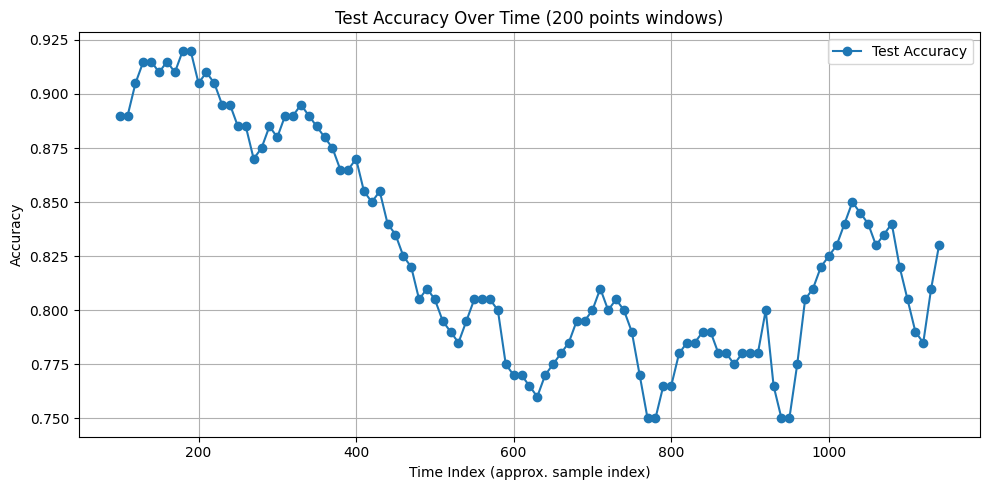

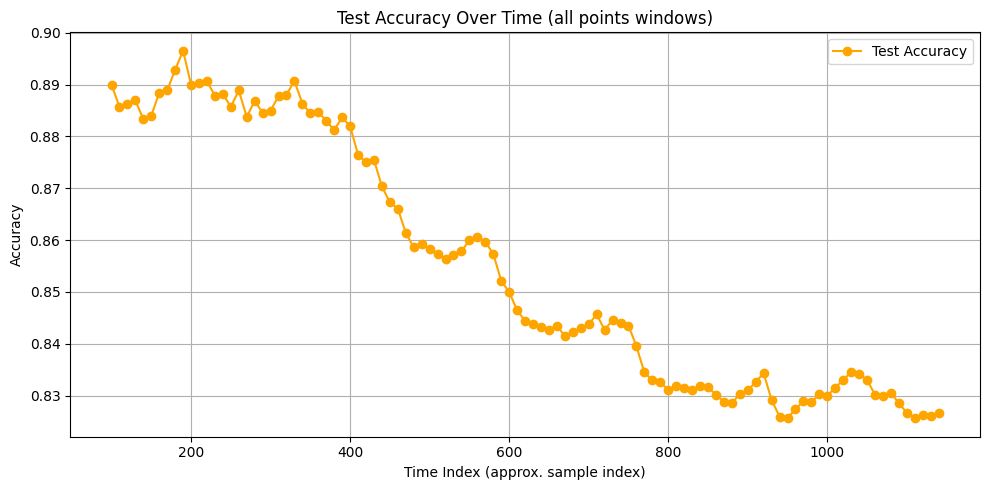

In [142]:
modelNN.eval()  # Set model to eval mode
accuracies = []
time_indices = []

window_preds = []
window_labels = []
window_size = 200  # Adjust as needed
step_size = 10

index = 0

# Collect all validation data in order
all_preds = []
all_labels = []


with torch.no_grad():
    for zs, x_extra, labels in test_loader:
        zs, x_extra, labels = zs.to(device), x_extra.to(device), labels.to(device)

        outputs = modelNN(zs, x_extra)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Now slide over the predictions and calculate accuracy
num_samples = len(all_preds)

for start in range(0, num_samples - window_size + 1, step_size):
    end = start + window_size
    preds_slice = all_preds[start:end]
    labels_slice = all_labels[start:end]

    acc = accuracy_score(labels_slice, preds_slice)
    accuracies.append(acc)
    time_indices.append(start + window_size // 2)  # midpoint

# Plot
plt.figure(figsize=(10, 5))
plt.plot(time_indices, accuracies, marker='o', label='Test Accuracy')
plt.xlabel("Time Index (approx. sample index)")
plt.ylabel("Accuracy")
plt.title("Test Accuracy Over Time (200 points windows)")
plt.grid(True)
plt.legend()
plt.tight_layout()
filename = f'{directory_name}/part4.1_accuracy_over_time_200.png'
plt.savefig(filename)
plt.show()

accuracies = []
time_indices = []
for start in range(0, num_samples - window_size + 1, step_size):
    end = start + window_size
    preds_slice = all_preds[0:end]
    labels_slice = all_labels[0:end]

    acc = accuracy_score(labels_slice, preds_slice)
    accuracies.append(acc)
    time_indices.append(start + window_size // 2)  # midpoint

# Plot
plt.figure(figsize=(10, 5))
plt.plot(time_indices, accuracies, marker='o', label='Test Accuracy', color = 'orange')
plt.xlabel("Time Index (approx. sample index)")
plt.ylabel("Accuracy")
plt.title("Test Accuracy Over Time (all points windows)")
plt.grid(True)
plt.legend()
plt.tight_layout()
filename = f'{directory_name}/part4.1_accuracy_over_time_absolute.png'
plt.savefig(filename)
plt.show()

## 4.2: Confusion matrices
Another check on performance can be done by computing the confusion matrices. Let's do this for all sets

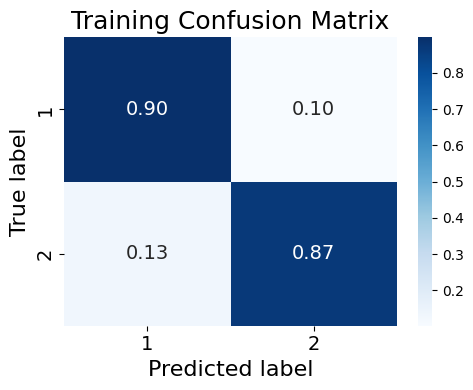

              precision    recall  f1-score   support

           0       0.93      0.90      0.91      3874
           1       0.81      0.87      0.84      1917

    accuracy                           0.89      5791
   macro avg       0.87      0.88      0.88      5791
weighted avg       0.89      0.89      0.89      5791



In [143]:
modelNN.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for zs, x_extra, labels in train_loader:
        zs, x_extra, labels = zs.to(device), x_extra.to(device), labels.to(device)
        logits = modelNN(zs, x_extra)
        _, predicted = torch.max(logits.data, 1)
        probs = torch.softmax(logits, dim=1)[:, 1]
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        
cm = confusion_matrix(all_labels, all_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot
plt.figure(figsize=(5, 4))
sns.heatmap(
    cm_normalized,
    annot=True,
    fmt=".2f",
    cmap='Blues',
    xticklabels=[1, 2],
    yticklabels=[1, 2],
    annot_kws={"size": 14}  # Font size for numbers in cells
)
plt.xlabel('Predicted label', fontsize=16)
plt.ylabel('True label', fontsize=16)
plt.title('Training Confusion Matrix', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
filename = f'{directory_name}/part4.2_corr_matrix_training.png'
plt.savefig(filename)
plt.show()

# Classification report
print(classification_report(all_labels, all_preds))

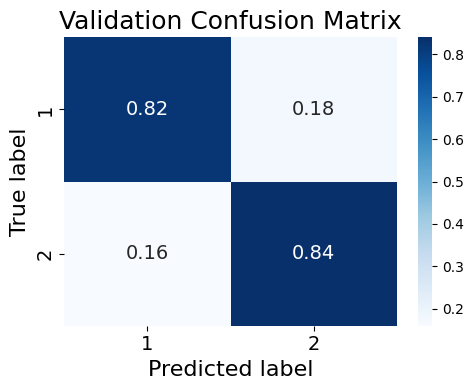

              precision    recall  f1-score   support

           0       0.86      0.82      0.84       677
           1       0.80      0.84      0.82       564

    accuracy                           0.83      1241
   macro avg       0.83      0.83      0.83      1241
weighted avg       0.83      0.83      0.83      1241



In [144]:
modelNN.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for zs, x_extra, labels in val_loader:
        zs, x_extra, labels = zs.to(device), x_extra.to(device), labels.to(device)
        logits = modelNN(zs, x_extra)
        _, predicted = torch.max(logits.data, 1)
        probs = torch.softmax(logits, dim=1)[:, 1]
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        
cm = confusion_matrix(all_labels, all_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot
plt.figure(figsize=(5, 4))
sns.heatmap(
    cm_normalized,
    annot=True,
    fmt=".2f",
    cmap='Blues',
    xticklabels=[1, 2],
    yticklabels=[1, 2],
    annot_kws={"size": 14}  # Font size for numbers in cells
)
plt.xlabel('Predicted label', fontsize=16)
plt.ylabel('True label', fontsize=16)
plt.title('Validation Confusion Matrix', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
filename = f'{directory_name}/part4.2_corr_matrix_validation.png'
plt.savefig(filename)
plt.show()

# Classification report
print(classification_report(all_labels, all_preds))

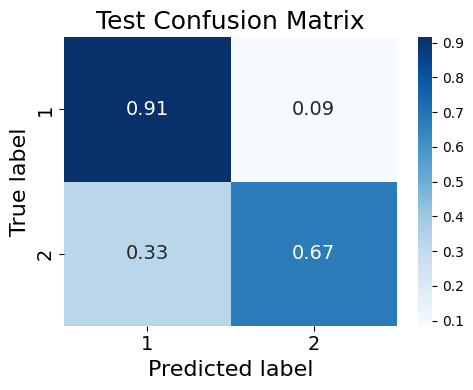

              precision    recall  f1-score   support

           0       0.83      0.91      0.87       787
           1       0.82      0.67      0.74       455

    accuracy                           0.83      1242
   macro avg       0.83      0.79      0.81      1242
weighted avg       0.83      0.83      0.82      1242



In [145]:
modelNN.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for zs, x_extra, labels in test_loader:
        zs, x_extra, labels = zs.to(device), x_extra.to(device), labels.to(device)
        logits = modelNN(zs, x_extra)
        _, predicted = torch.max(logits.data, 1)
        probs = torch.softmax(logits, dim=1)[:, 1]
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        
cm = confusion_matrix(all_labels, all_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot
plt.figure(figsize=(5, 4))
sns.heatmap(
    cm_normalized,
    annot=True,
    fmt=".2f",
    cmap='Blues',
    xticklabels=[1, 2],
    yticklabels=[1, 2],
    annot_kws={"size": 14}  # Font size for numbers in cells
)
plt.xlabel('Predicted label', fontsize=16)
plt.ylabel('True label', fontsize=16)
plt.title('Test Confusion Matrix', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
filename = f'{directory_name}/part4.2_corr_matrix_test.png'
plt.savefig(filename)
plt.show()

# Classification report
print(classification_report(all_labels, all_preds))

## 4.3 ROC Curve
Another interesting metric for evaluating the performance of the model is the ROC curve. The higher the area under the curve, the better is the model in interpreting the classes 

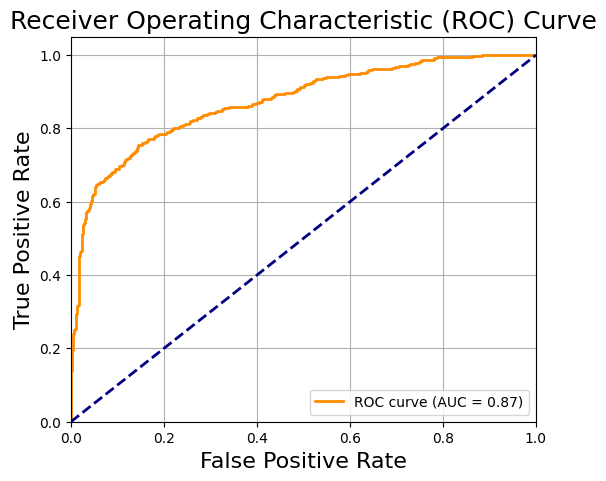

In [146]:
fpr, tpr, thresholds = roc_curve(all_labels, all_probs, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize = 16)
plt.ylabel('True Positive Rate', fontsize = 16)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize = 18)
plt.legend(loc="lower right")
plt.grid(True)
filename = f'{directory_name}/part4.3_ROC.png'
plt.savefig(filename)
plt.show()


# 5: Performance check with SVM
Since the latent space of the VAE is clearly clustered across the classes, we want to compare NN results with the ones obtained with a "classic" ML tecnique, SVM

In [147]:
from sklearn.svm import NuSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

def extract_features_labels(dataset_subset):
    zs_feats, extra_feats, labels = [], [], []
    for zs, extra, y in tqdm(dataset_subset, desc="Extracting features"):
        zs_feats.append(zs.numpy())
        extra_feats.append(extra.numpy())
        labels.append(y.numpy() if hasattr(y, 'numpy') else y)
    X = np.concatenate([np.vstack(zs_feats), np.vstack(extra_feats)], axis=1)
    y = np.array(labels)
    return X, y

# extract from subsets
X_train, y_train = extract_features_labels(train_dataset)
X_val, y_val = extract_features_labels(val_dataset)
X_test, y_test = extract_features_labels(test_dataset)

param_grid = {
    'nu': [0.01, 0.05, 0.1, 0.3],
    'kernel': ['linear', 'rbf', 'poly','sigmoid'],
    'degree': [2,3,4],
    'gamma': ['scale', 'auto']
}

best_score = 0
best_params = None

param_combinations = list(product(*param_grid.values()))

for params in tqdm(param_combinations, desc="Grid Search"):
    nu, kernel, degree, gamma = params
    #print(f"\nTraining with: C={C}, kernel={kernel}, gamma={gamma}")

    clf = NuSVC(nu = nu, kernel=kernel, degree = degree, gamma=gamma)
    clf.fit(X_train, y_train)  # train on full train set
    val_pred = clf.predict(X_val)
    score = accuracy_score(y_val, val_pred)
    if score > best_score:
        best_score = score
        best_params_SVM = {'nu': nu, 'kernel': kernel, 'gamma': gamma, 'degree':degree}
        print(f'New best score obtained! Score: {best_score}')
        print('Params:',params,'\n')

print("Best Params:", best_params_SVM)
print("Validation Accuracy:", best_score)

# Train final model on full train set with best params
final_clf = NuSVC(**best_params_SVM)
final_clf.fit(X_train, y_train)

# Test evaluation
test_pred = final_clf.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, test_pred))

Extracting features:   0%|          | 0/5791 [00:00<?, ?it/s]

Extracting features:   0%|          | 0/1241 [00:00<?, ?it/s]

Extracting features:   0%|          | 0/1242 [00:00<?, ?it/s]

Grid Search:   0%|          | 0/96 [00:00<?, ?it/s]

New best score obtained! Score: 0.45447219983883963
Params: (0.01, 'linear', 2, 'scale') 

New best score obtained! Score: 0.5221595487510072
Params: (0.01, 'rbf', 2, 'auto') 

New best score obtained! Score: 0.5503626107977437
Params: (0.01, 'poly', 2, 'scale') 

New best score obtained! Score: 0.5850120870265915
Params: (0.05, 'poly', 4, 'scale') 

New best score obtained! Score: 0.5995165189363416
Params: (0.05, 'poly', 4, 'auto') 

New best score obtained! Score: 0.6204673650282031
Params: (0.1, 'poly', 4, 'scale') 

New best score obtained! Score: 0.6293311845286059
Params: (0.1, 'poly', 4, 'auto') 

New best score obtained! Score: 0.797743755036261
Params: (0.3, 'rbf', 2, 'scale') 

New best score obtained! Score: 0.798549556809025
Params: (0.3, 'rbf', 2, 'auto') 

Best Params: {'nu': 0.3, 'kernel': 'rbf', 'gamma': 'auto', 'degree': 2}
Validation Accuracy: 0.798549556809025
Test Accuracy: 0.8365539452495975


## 5.1: SVM Confusion matrices

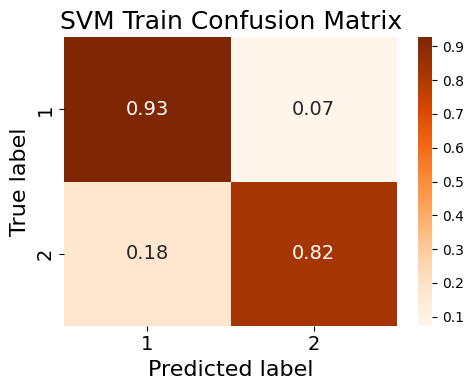

In [148]:
cm = confusion_matrix(y_train,final_clf.predict(X_train))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# plot
plt.figure(figsize=(5, 4))
sns.heatmap(
    cm_normalized,
    annot=True,
    fmt=".2f",
    cmap='Oranges',
    xticklabels=[1, 2],
    yticklabels=[1, 2],
    annot_kws={"size": 14}  # font size for numbers in cells
)
plt.xlabel('Predicted label', fontsize=16)
plt.ylabel('True label', fontsize=16)
plt.title('SVM Train Confusion Matrix', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
filename = f'{directory_name}/part5.2_SVM_corr_matrix_train.png'
plt.savefig(filename)
plt.show()


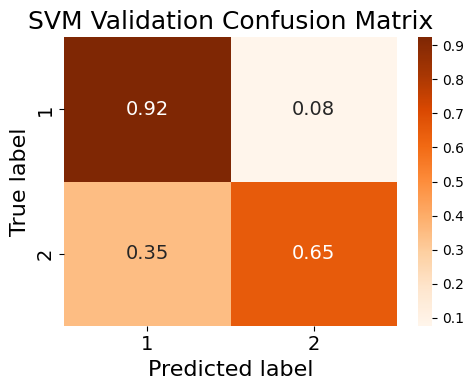

In [149]:
cm = confusion_matrix(y_val,final_clf.predict(X_val))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# plot
plt.figure(figsize=(5, 4))
sns.heatmap(
    cm_normalized,
    annot=True,
    fmt=".2f",
    cmap='Oranges',
    xticklabels=[1, 2],
    yticklabels=[1, 2],
    annot_kws={"size": 14}  # font size for numbers in cells
)
plt.xlabel('Predicted label', fontsize=16)
plt.ylabel('True label', fontsize=16)
plt.title('SVM Validation Confusion Matrix', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
filename = f'{directory_name}/part5.2_SVM_corr_matrix_valid.png'
plt.savefig(filename)
plt.show()


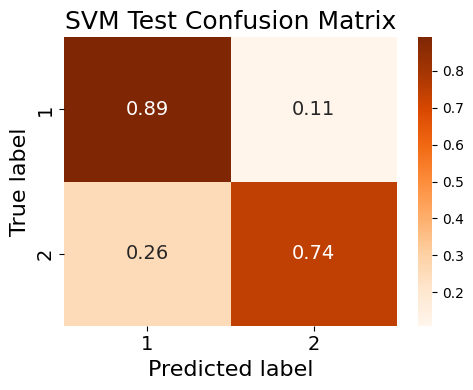

In [150]:
cm = confusion_matrix(y_test,final_clf.predict(X_test))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# plot
plt.figure(figsize=(5, 4))
sns.heatmap(
    cm_normalized,
    annot=True,
    fmt=".2f",
    cmap='Oranges',
    xticklabels=[1, 2],
    yticklabels=[1, 2],
    annot_kws={"size": 14}  # font size for numbers in cells
)
plt.xlabel('Predicted label', fontsize=16)
plt.ylabel('True label', fontsize=16)
plt.title('SVM Test Confusion Matrix', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
filename = f'{directory_name}/part5.2_SVM_corr_matrix_test.png'
plt.savefig(filename)
plt.show()


## 5.3: time-aware SVM accuracy

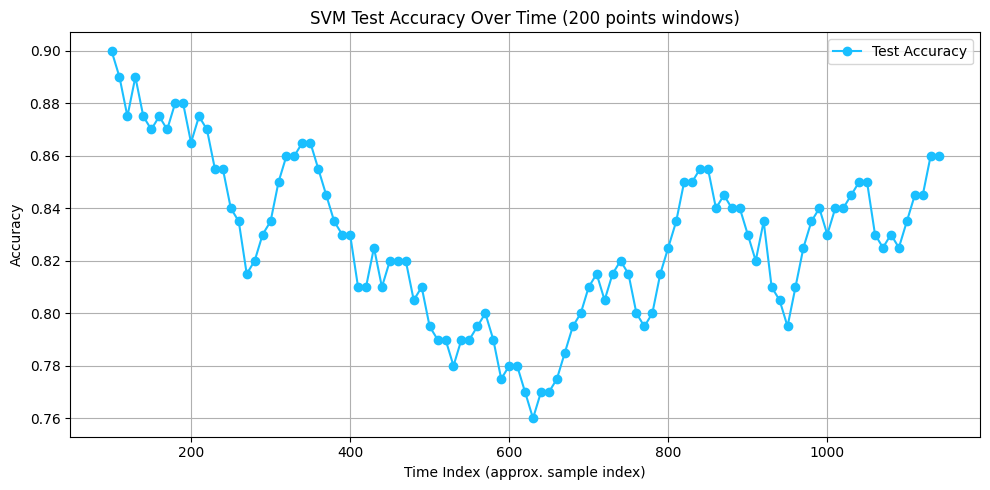

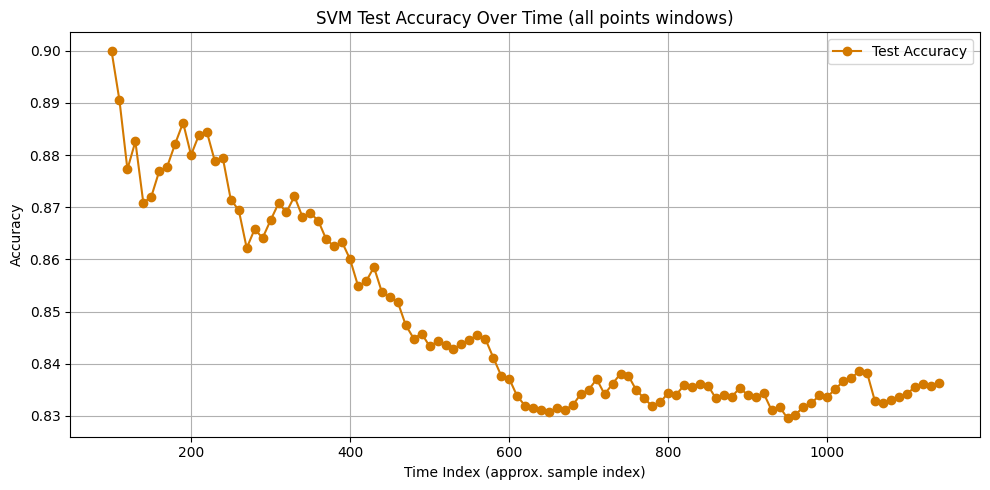

In [151]:

accuracies = []
time_indices = []
window_preds = []
window_labels = []
window_size = 200  # Adjust as needed
step_size = 10
index = 0
# Collect all validation data in order
all_preds = []
all_labels = []


for i in range(len(y_test)):
    all_preds.append(final_clf.predict(X_test[i,:].reshape(1,-1))[0])
    all_labels.append(y_test[i])
    
# Now slide over the predictions and calculate accuracy
num_samples = len(all_preds)

for start in range(0, num_samples - window_size + 1, step_size):
    end = start + window_size
    preds_slice = all_preds[start:end]
    labels_slice = all_labels[start:end]

    acc = accuracy_score(labels_slice, preds_slice)
    accuracies.append(acc)
    time_indices.append(start + window_size // 2)  # midpoint

# Plot
plt.figure(figsize=(10, 5))
plt.plot(time_indices, accuracies, marker='o', label='Test Accuracy', c='#1ABFFF')
plt.xlabel("Time Index (approx. sample index)")
plt.ylabel("Accuracy")
plt.title("SVM Test Accuracy Over Time (200 points windows)")
plt.grid(True)
plt.legend()
plt.tight_layout()
filename = f'{directory_name}/part5.3_SVM_accuracy_over_time_200.png'
plt.savefig(filename)
plt.show()

accuracies = []
time_indices = []
for start in range(0, num_samples - window_size + 1, step_size):
    end = start + window_size
    preds_slice = all_preds[0:end]
    labels_slice = all_labels[0:end]

    acc = accuracy_score(labels_slice, preds_slice)
    accuracies.append(acc)
    time_indices.append(start + window_size // 2)  # midpoint

# Plot
plt.figure(figsize=(10, 5))
plt.plot(time_indices, accuracies, marker='o', label='Test Accuracy', color = '#D37900')
plt.xlabel("Time Index (approx. sample index)")
plt.ylabel("Accuracy")
plt.title("SVM Test Accuracy Over Time (all points windows)")
plt.grid(True)
plt.legend()
plt.tight_layout()
filename = f'{directory_name}/part5.3_SVM_accuracy_over_time_absolute.png'
plt.savefig(filename)
plt.show()